In [1]:
# A note to other users:

# This is roughly broken into 3 sections: The data_gathering() section which 
# pulls data from the text files (stored in ../data , a directory just outside
# of the directory that this program is being ran from), the data_analysis() section
# which removes jump artifacts (an on-off happening at the same time, which is meaningless
# to the evolution but is a side effect of allowing for more jumps than expected), and the
# plot_data() section. These are called in order from a 'main' below the three sections. Keep in mind that
# jupyter keeps the most recently ran declaration/definition, so if you're making a change to a
# data_analysis() function for example, you must rerun that cell (shift+ENTER for most computers) in order
# for those changes to show up when calling 'main'. Similarly, if this is your first time opening the notebook
# for the day, you must run all of the cells in order for them to be loaded into memory.

In [2]:
import sys
import os
import shutil
import errno
from glob import glob
from decimal import Decimal
from pylab import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import glob
import re
from IPython.display import set_matplotlib_formats
from ast import literal_eval
import scipy.optimize as optimize
from scipy.optimize import curve_fit
from mpl_toolkits import mplot3d

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 7,5
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

#cmap=plt.cm.viridis
cmap=plt.cm.coolwarm

# Single Data Set Class

In [3]:
class data_set:
    def __init__(self, filepath):     
        params, data_for_file = get_params(filepath), get_data(filepath)

        self.filepath = filepath
        self.sim_type, self.dim, self.occ =  (filepath.split("___")[0])[len(filepath.split("___")[0])-4:], int((filepath.split("x")[0])[-1]), int((filepath.split("_occupants")[0])[-1])
        self.ji, self.ki, self.jt, self.kt = float(get_values(params, "j_initial")), float(get_values(params, "k_initial")), float(get_values(params, "j_target")), float(get_values(params, "k_target"))
        self.initial_e, self.ground_e = float(get_values(params, "INITIAL_E")), float(get_values(params, "GROUND_E"))
        self.initial_state, self.target_state = get_values(params, "init_state"), get_values(params, "target_state") 
        self.init_target_dot_squared, self.num_seeds =float(get_values(params, "init_target_dot_squared")), int(get_values(params, "NUM_SEEDS"))
        self.tau_initial, self.max_tau = float(get_values(params, "TAU_INIT")), float(get_values(params, "MAX_TAU"))
        self.energy_space = bool(get_values(params, "USE_ENERGY_DISTANCE"))  
        if(get_values(params, "USE_ENERGY_DISTANCE") == "false"): self.energy_space = False
        else: self.energy_space = True
        
        
        self.j_protocols               = get_values(data_for_file, "j_protocols")
        self.k_protocols               = get_values(data_for_file, "k_protocols")
        self.tau_array                 = get_values(data_for_file, "tau_array")
        self.best_mc_result_array      = get_values(data_for_file, "best_mc_result_array")
        self.distance_array            = get_values(data_for_file, "distance_array")
        self.best_mc_result_fixed_tau_array    = get_values(data_for_file, "best_mc_result_fixed_tau_array")
        self.total_steps_array         = get_values(data_for_file, "total_steps_array")
        self.time_step_array           = get_values(data_for_file, "time_step_array")
        self.clock_array               = get_values(data_for_file, "clock_array")
        self.overlap_array             = get_values(data_for_file, "overlap_array")
        self.best_state_array          = get_values(data_for_file, "best_state_array")
        self.evolved_state_fixed_tau   = get_values(data_for_file, "evolved_state_fixed_tau")
        
        self.tau_critical              = self.tau_array[-1]
        if(self.tau_critical == 0): self.skip = True
        else: self.skip = False
        self.tau_extrapolated = 0
        self.j_protocols_reduced, self.k_protocols_reduced = [],[]
        self.j_jumps, self.k_jumps = [],[]
        self.j_char_and_total_time, self.j_char_and_total_time_over_tau = [],[]
        self.k_char_and_total_time, self.k_char_and_total_time_over_tau = [],[]
        self.comparisons = []
    
    def find_optimal_seeds(self):
        
        if(self.sim_type != "ADIA"):
            for x in range(len(self.best_mc_result_fixed_tau_array)):
                #if(len(self.best_mc_result_fixed_tau_array[x])> 1):
                best_E_index = self.best_mc_result_fixed_tau_array[x].index(min(self.best_mc_result_fixed_tau_array[x]))
                self.j_protocols[x],self. k_protocols[x] = self.j_protocols[x][best_E_index], self.k_protocols[x][best_E_index]
                    #self.best_mc_result_fixed_tau_array[x] = self.best_mc_result_fixed_tau_array[x][best_E_index]
            self.best_mc_result_fixed_tau_array = []
            
        if(self.overlap_array[-1] == 0): self.overlap_array = [float(self.init_target_dot_squared)]        


    def remove_non_monotonic_behavior(self):
        array_collection = [self.tau_array, self.best_mc_result_array, self.distance_array,
                            self.clock_array, self.overlap_array, self.best_state_array]

        if(self.sim_type == "MCDB" or self.sim_type == "MCBF"): array_collection.append(self.total_steps_array), array_collection.append(self.time_step_array)
        if(self.sim_type != "ADIA"): array_collection.append(self.j_protocols), array_collection.append(self.k_protocols)

        size = len(self.best_mc_result_array)
        x=0
        while(x<size):
            lowest_E = self.best_mc_result_array[x]
            y=x+1
            while(y<size):
                if(self.best_mc_result_array[y] > lowest_E):
                    for array in array_collection:
                        array.pop(y)
                    size-=1
                y+=1
            x+=1
        for x in range(0, size-1, 1):
            if((self.energy_space and self.distance_array[x]<DISTANCE_CUTOFF and self.distance_array[x] != 0) or ((not self.energy_space) and 1-self.overlap_array[x]<OVERLAP_CUTOFF)):
                for y in range(x+1, size-1, 1):
                    for array in array_collection:
                        array.pop(-1)
                break

        self.tau_critical = self.tau_array[-1]
                    

    
    def remove_jump_artifacts(self):
        self.j_protocols_reduced,self.k_protocols_reduced = [],[]

        if(self.skip): self.j_protocols_reduced.append([0]),self.k_protocols_reduced.append([0])
        else:    
            for y in range(len(self.tau_array)):

                if(self.sim_type == "MCDB"): j,k = convert_mcdb((self.j_protocols[y]).copy(), self.tau_array[y], self.time_step_array[y]),convert_mcdb((self.k_protocols[y]).copy(), self.tau_array[y], self.time_step_array[y])
                if(self.sim_type == "MCBB"): j,k = (self.j_protocols[y]).copy(), (self.k_protocols[y]).copy()
                self.j_protocols_reduced.append(reduce_protocol(j, self.tau_array[y]))
                self.k_protocols_reduced.append(reduce_protocol(k, self.tau_array[y]))

    def extrapolate_pre_convergence_time(self):
        if(self.skip): return
        
        taus = np.array(self.tau_array)
        distance = np.array(self.distance_array)
        tau_line = np.poly1d(np.polyfit(distance, taus,1))
        self.tau_extrapolated= max(tau_line(0), taus[-1])
        

        point_within_dist_lim = np.where(np.array(self.distance_array) < DISTANCE_LIMIT)[0]
        if (len(point_within_dist_lim) > 1):

            taus = np.array(self.tau_array)[point_within_dist_lim]
            distance = np.array(self.distance_array)[point_within_dist_lim]
            tau_line = np.poly1d(np.polyfit(distance, taus,1))
            #tau_line = np.poly1d([linear_fit_through_0(best_Es, taus), 0])
            self.tau_extrapolated= max(tau_line(0), taus[-1])
                       
        
    def calc_num_jumps(self):
        self.j_jumps, self.k_jumps = [],[]

        
        if(self.skip): self.j_jumps.append(0), self.k_jumps.append(0)
        else:
            for y in range(len(self.tau_array)):
                j,k = (self.j_protocols_reduced[y]).copy(),(self.k_protocols_reduced[y]).copy()
                if(j[-1] == self.tau_critical): del j[-1]
                if(k[-1] == self.tau_critical): del k[-1]
                j_jump, k_jump = len(j[::2]), len(k[::2])
                self.j_jumps.append(j_jump), self.k_jumps.append(k_jump)  

        

    def calc_characteristic_times(self):
        self.j_char_and_total_time, self.j_char_and_total_time_over_tau = [],[]
        self.k_char_and_total_time, self.k_char_and_total_time_over_tau = [],[]
        
        if(self.skip): 
            self.j_char_and_total_time.append([0,0,0,0]),self.j_char_and_total_time_over_tau.append([0,0,0,0])
            self.k_char_and_total_time.append([0,0,0,0]),self.k_char_and_total_time_over_tau.append([0,0,0,0])
            return
        
        for x in range(len(self.tau_array)):
        
            j, k = (self.j_protocols_reduced[x]).copy(), (self.k_protocols_reduced[x]).copy()
            self.j_char_and_total_time.append(calc_char_and_total_time(j,self.tau_critical, 1)), 
            self.j_char_and_total_time_over_tau.append(calc_char_and_total_time(j,self.tau_critical, self.tau_critical))
            self.k_char_and_total_time.append(calc_char_and_total_time(k,self.tau_critical, 1))
            self.k_char_and_total_time_over_tau.append(calc_char_and_total_time(k,self.tau_critical, self.tau_critical))

## Directory Object

In [4]:
class dir_object:
    
    def __init__(self, my_dir,skip=[]):
        self.mcbb_data, self.mcbf_data, self.mcdb_data, self.adia_data = [],[],[],[]
        self.dim, self.occ = int((my_dir.split("x")[0])[-1]), int(((my_dir.split("/")[-2]).split("_"))[0])
        self.dir_name = my_dir

        for filepath in glob.iglob(my_dir + '*.txt'):
            print("     Working on: ", filepath)
            if("MCBB" in filepath and "MCBB" not in skip):   self.mcbb_data.append(data_set(filepath))
            elif("MCDB" in filepath and "MCDB" not in skip): self.mcdb_data.append(data_set(filepath))
            elif("MCBF" in filepath and "MCBF" not in skip): self.mcbf_data.append(data_set(filepath))
            elif("ADIA" in filepath and "ADIA" not in skip): self.adia_data.append(data_set(filepath))

# Data Gathering Functions

In [5]:
def get_all_data(my_dirs, skip=[]):
    data = []
    for my_dir in my_dirs:
        print("... Getting data for the directory: ", my_dir)
        dir_ = dir_object(my_dir,skip=skip)
        data.append(dir_)
            
    return data



def get_values(dictionary, name):
    try:
        names = dictionary[0]
        values = dictionary[1]
        index = names.index(name)
        return values[index]
    except:
        return False



def get_params(filepath):
    names, values = [], []       
    file = open(filepath, "rt")
   
    for line in file:
        
        if "START_PARAMETERS" in line: continue
        if "END_PARAMETERS" in line: break
            
        line = line.rstrip("\n")
        line_split = line.rstrip("\n").split(' ')
        name = line_split[0].rstrip("=")
        
        if(name == "init_state" or name == "target_state"): 
            value = literal_eval((line.split('=')[-1]).replace(" ", ""))
        else: 
            value = line_split[-1]
            
        names.append(name) 
        values.append(value)
      
    return [names, values]



def get_data(filepath): 
    parameters = get_params(filepath)
    names, values = [], []
    j_protocols, k_protocols, b_protocols  = [], [],[]
    tau_array, best_mc_result_array, total_steps_array, time_step_array, distance_array, best_mc_result_fixed_tau_array  = [],[],[],[],[],[]
    clock_array, overlap_array, best_state_array, evolved_state_fixed_tau = [],[],[],[]
    for line in open(filepath, "rt"):     
        line = line.rstrip("\n")
        if line.startswith('clock_duration'): clock_array.append(float((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('tau'): tau_array.append(float((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('best_mc_result_fixed_tau'): best_mc_result_fixed_tau_array.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('evolved_state_fixed_tau'): evolved_state_fixed_tau.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('best_evolved_state'): best_state_array.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('evolved_target_dot_squared'): overlap_array.append(float((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('best_mc_result'): best_mc_result_array.append(float((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('distance'): distance_array.append(float((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('j_protocol'): j_protocols.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('k_protocol'): k_protocols.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('b_protocol'): b_protocols.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('total_steps'): total_steps_array.append(int((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('time_step'): time_step_array.append(float((line.split('=')[-1]).replace(" ", "")))

    potential_names = ['parameters', 'j_protocols','k_protocols','b_protocols',
                       'tau_array', 'best_mc_result_array', 'distance_array', 
                       'best_mc_result_fixed_tau_array','total_steps_array', 'time_step_array',
                      'clock_array', 'overlap_array', 'best_state_array','evolved_state_fixed_tau']
    potential_values = [parameters, j_protocols, k_protocols, b_protocols,
                        tau_array, best_mc_result_array, distance_array,
                        best_mc_result_fixed_tau_array, total_steps_array, time_step_array,
                       clock_array, overlap_array, best_state_array, evolved_state_fixed_tau]
    
    for x in range(len(potential_values)):
        if (len(potential_values[x]) == 0): continue
        names.append(potential_names[x])
        values.append(potential_values[x])
    return [names, values]

# Analysis Functions

In [24]:
def analyze_data(data,initial_sets, target_sets):
    for dir_ in data:
        print("... Analyzing data for the directory: ", dir_.dir_name)
        for data_set in (dir_.mcbf_data + dir_.mcbb_data+dir_.mcdb_data+dir_.adia_data):
            data_set.find_optimal_seeds()
            data_set.remove_non_monotonic_behavior()
            data_set.extrapolate_pre_convergence_time()  
        for data_set in (dir_.mcdb_data + dir_.mcbb_data):
            data_set.remove_jump_artifacts()
            data_set.calc_num_jumps()
            data_set.calc_characteristic_times()

        compare_protocols(dir_.mcdb_data ,initial_sets, target_sets)



def reduce_protocol(protocol, tau):
    collapse_limit = tau*COLLAPSE_LIMIT_FRACTION
    limit = tau/256
    while(limit <= collapse_limit):
        index, max_loops = 0, len(protocol)
        while(index<max_loops-1):
            if(abs(protocol[index]-protocol[index+1]) <= limit):
                del protocol[index+1]
                del protocol[index]
                max_loops -= 2
            else: index += 1  
        limit=limit*2
        
    index, max_loops = 0, len(protocol)
    while(index<max_loops-1):
        if(abs(protocol[index]-protocol[index+1]) <= collapse_limit):
            del protocol[index+1]
            del protocol[index]
            max_loops -= 2
        else: index += 1      
    if(tau not in protocol):  protocol.append(tau)

    return protocol



def convert_mcdb(protocol, tau, time_step):
    converted_protocol = []
    if(protocol[0] == 1): converted_protocol.append(0)
    for z in range(len(protocol)-1): 
        if(protocol[z] != protocol[z+1]): converted_protocol.append(time_step*(z+1))
    if(tau not in converted_protocol): converted_protocol.append(tau) 
    
    return converted_protocol


  
def calc_char_and_total_time(protocol,tau, norm): 
    char_time = []

    protocol.insert(0,0), protocol.append(tau)
    for y in range(len(protocol) - 1): #iterate over each tau
        char_time.append(protocol[y+1]-protocol[y])

    num_1s,char_1,num_0s, char_0 = 0,0,0,0

    for y in range(len(char_time)):
        if(char_time[y] > 0.000001):
            if(y%2 == 0):
                char_1 += char_time[y]
                num_1s += 1
            else:
                char_0 += char_time[y]
                num_0s += 1
    
    total_1 = char_1
    total_0 = char_0
    
    if(num_1s > 0): char_1 = char_1/num_1s
    if(num_0s > 0): char_0 = char_0/num_0s

    return [char_1/norm, char_0/norm, total_1/norm, total_0/norm] 




def get_data_sets(data_sets, ri=False, rt=False, ji=False, ki=False, jt=False, kt=False, consider_skip = False):
    ds_list = []
    
    for ds in data_sets:
        conditions = []
        if(ri): conditions.append(math.log(ds.ji/ds.ki) == ri)
        if(rt): conditions.append(math.log(ds.jt/ds.kt) == rt)
        if(ji): conditions.append(ds.ji == ji)
        if(ki): conditions.append(ds.ki == ki)
        if(jt): conditions.append(ds.jt == jt)
        if(kt): conditions.append(ds.kt == kt)
        if(consider_skip): conditions.append(ds.skip == False)
        if all(conditions):
            ds_list.append(ds)
            
            
    return ds_list
        
def compare_protocols(data_mcdb,initial_sets, target_sets):
    if(len(initial_sets) != len(target_sets)): 
        print("Error, targetsets need to be the same length as initial sets")
        return

    j_comp, k_comp, j_jumps_comp, k_jumps_comp, skip_comp = [], [],[], [], []
    for x in range(len(initial_sets)):
    
        data_set = get_data_sets(data_mcdb, ri=initial_sets[x], rt=target_sets[x])[0]
        if(data_set.skip): skip_comp.append(True),j_comp.append([0]),k_comp.append([0]),j_jumps_comp.append([0]), k_jumps_comp.append([0])
        else:
            skip_comp.append(False)
            j_comp.append(data_set.j_protocols_reduced[-1]),k_comp.append(data_set.k_protocols_reduced[-1])
            j_jumps_comp.append(data_set.j_jumps[-1]),k_jumps_comp.append(data_set.k_jumps[-1])
    
    
    for data_set in data_mcdb:
        data_set.comparisons = []
        for x in range(len(initial_sets)):
            if(data_set.skip or skip_comp[x]): data_set.comparisons.append([0,0,0,0])
            else:
                data_set.comparisons.append([protocol_correlation_func_mod(data_set.j_protocols_reduced[-1],j_comp[x],data_set.j_jumps[-1],j_jumps_comp[x]),
                                         protocol_correlation_func_mod(data_set.k_protocols_reduced[-1],k_comp[x],data_set.k_jumps[-1],k_jumps_comp[x]),
                                         protocol_correlation_func(data_set.j_protocols_reduced[-1],j_comp[x]),
                                             protocol_correlation_func(data_set.k_protocols_reduced[-1],k_comp[x])])



    
def protocol_correlation_func_mod(p1, p2, m, n):
    
    calculated_correlation = protocol_correlation_func(p1, p2)
    expected_correlation = get_expected_corr(m,n)
    
    return calculated_correlation-expected_correlation
    
    
    
def protocol_correlation_func(p1, p2):

    p1_tau, p2_tau = p1[-1], p2[-1]
    p1 = [time/p1_tau for time in p1] 
    p2 = [time/p2_tau for time in p2]
    
    total_overlap, time_previous, p1_on, p2_on = 0,0,1,1
    combined = sorted(p1 + p2)
    if(len(combined) == 1): print("\n\n\n\n\n\nERROR IN THE COMBININIG PROCESS FOR CORR FUNC\n\n\n\n\n")
    
    for time in combined:
        change = time-time_previous
        if(p1_on == p2_on): total_overlap += change
        if time in p1: p1_on = (p1_on + 1) %2
        if time in p2: p2_on = (p2_on + 1) %2
        time_previous = time
    
    return total_overlap



def get_expected_corr(m,n):
    if(m > 9): m=9
    if(n > 9): n=9
    expected_correlations = [[0.600147699776004, 0.5712338748765787, 0.5555706967606777, 0.545351209247155, 0.5385122185142767, 0.5335012020313474, 0.5293666881686706, 0.5259367785861887, 0.5238379223172802, 0.5216693681525312], [0.5712929959015195, 0.5555713057017088, 0.5453883225405965, 0.5385595284656947, 0.5332274057739077, 0.5294230035598351, 0.5263729469380182, 0.5237016184402828, 0.5216695264578064, 0.5199314875204598], [0.5556319572257781, 0.5456761455174851, 0.5384495817319188, 0.5331442968545845, 0.5294449798813218, 0.5265139448953233, 0.5239297876122827, 0.5216165044533978, 0.5199609420884219, 0.5185286101250256], [0.5455508272871546, 0.5383901612266245, 0.5332787307409023, 0.5294839522564326, 0.5263652388409229, 0.5238420190190826, 0.5218591701565214, 0.5200402837103295, 0.5186079110502778, 0.5171385712163025], [0.5384483814457044, 0.533418958468794, 0.5294713196588129, 0.5264563917918658, 0.5238889397143583, 0.5218897823623183, 0.5201441959910578, 0.5185074994355018, 0.5172205738897399, 0.5162763929423091], [0.5333681889795245, 0.5294580039600845, 0.5264955121633532, 0.5238787681787044, 0.5217922557062405, 0.5198880075237334, 0.5184343127966805, 0.5172295750325734, 0.5162921032332515, 0.5151550668422256], [0.5295057310160771, 0.526327509178634, 0.5236768475898073, 0.521693164949027, 0.5199382197671717, 0.5185104651267554, 0.5173439007974567, 0.5159828733240488, 0.5152130447646509, 0.514171569975028], [0.5263374296354152, 0.5239081033380923, 0.521738951031868, 0.5199491475361656, 0.5185300834998675, 0.5172774565162734, 0.5161220947223192, 0.5152386380120277, 0.5142645985315033, 0.5135437387051474], [0.523995327410501, 0.521836177931003, 0.5199402753868384, 0.5186277629012794, 0.5170762214438477, 0.516129752394632, 0.5152403325768585, 0.5141881920747723, 0.5134750261942919, 0.5128472724710921], [0.5216974886704653, 0.5200640505739937, 0.5184879226904646, 0.517226650454048, 0.5162065085226006, 0.5150594402109683, 0.5142204109955493, 0.5134182267436602, 0.5128908595219885, 0.5121670079612185]]
    return(expected_correlations[m-1][n-1])



def choose(N, r):
    if(N < r): return -1
    total = 1
    for y in range(N,r,-1):
        total = total*y
    for y in range(1,N-r+1):
        total = total/y
    return total


def inner_product_squared(ts1,ts2):
    real, im = 0,0
    if(len(ts1) != len(ts2)): 
        print("AKLSJDAKLJDKLA")
        return
    for x in range(int(len(ts1)/2)):
        r1,i1,r2,i2 = ts1[2*x], ts1[2*x+1],ts2[2*x], ts2[2*x+1]
        real += r1*r2+i1*i2
        im   += i1*r2-i2*r1
    return real*real +im*im



def truncate(number, digits) -> float:
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper

def powerlaw(r, r0, c, alpha):
    return c*(r-r0)**alpha


def calc_chi_sq(observed, expected):
    o = observed
    e = expected

    chi_sq = 0
    for x in range(len(observed)):
        chi_sq += ((e[x]-o[x])**2)/e[x]
        
    return chi_sq



def closest(lst, K): 
    lst = lst.copy()
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))] 

# Plotting Functions

In [19]:
def save_plot(dir_, title):
    if not os.path.exists("figures/" + dir_): os.makedirs("figures/" + dir_)
    plt.savefig("figures/" + dir_ + title + ".pdf")
    

def step_plot(x, y, title, x_label,color, y_label, x_upper, x_lower, y_upper, y_lower):
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.xlim(x_lower, x_upper)
    plt.ylim(y_lower, y_upper)
    if(x[0]!=0): x.insert(0,0), y.insert(0,1)
    plt.step(x,y, c=color)
    
    
def state_overlap_plots(data):
    for dir_ in data:
        rts = [math.log(ds.jt/ds.kt) for ds in dir_.mcdb_data]
        ts  = [ds.target_state for ds in dir_.mcdb_data]
        target, target_states =[],[]
        for x in range(len(rts)):
            if rts[x] not in target:
                target.append(rts[x])
                target_states.append(ts[x])

        x,y,dot = [],[],[]
        for rt1,ts1 in zip(target,target_states):
            for rt2,ts2 in zip(target,target_states):
                x.append(rt1), y.append(rt2), dot.append(inner_product_squared(ts1,ts2))
        plt.figure()
        plt.title(r"$(\langle\psi_{target}(r_t)|\psi_{target}(r_t)\rangle)^2$, Nx="+str(dir_.dim)+", occupants="+str(dir_.occ))
        plt.ylabel(r"$ln(r_t)$")
        plt.xlabel(r"$ln(r_t)$")
        plt.scatter(x,y,c=dot,cmap=cmap, marker = "s", s=100)
        plt.colorbar(label=r"$(\langle\psi_{target}(r_t)|\psi_{target}(r_t)\rangle)^2$")
        if(dir_.dim == 3 and dir_.occ ==4): save_plot("ri_rt_color_plots/","3x3_4_occ_target_overlap") 
            
            
            
def make_color_plots(data,dim = 0, occ = 0, save=False, tau_extrapolated = False,group_plot = True):
    
    M,N = 5,2
    msize=50*(not group_plot)+20*group_plot
    titles = [r"$\tau_{mcdb}$", r"$|\langle\psi_{evolved}|\psi_{target}\rangle|^2$", r"$J_{jumps}$", r"$K_{jumps}$", r"$C(\{J_i\})_m$",  r"$C(\{K_i\})_m$", r"$C(\{J_i\})_m$", r"$C(\{K_i\})_m$", r"$\frac{J_{on}}{\tau}$", r"$\frac{K_{on}}{\tau}$"]
    vmin = [None, None, 0, 0, -0.6,-0.6,-0.6,-0.6,0,0]
    vmax = [None, None, 6, 6,  0.5, 0.5, 0.5, 0.5,1,1]
    a = matplotlib.colors.BoundaryNorm(np.arange(-0.5,5.5,1), cmap.N)
    norm = [None, None, a,a, None, None, None, None, None, None]
    ticks = [None, None, np.linspace(0,5,6), np.linspace(0,5,6), np.arange(-0.45,0.66,0.2), np.arange(-0.45,0.66,0.2), np.arange(-0.45,0.66,0.2), np.arange(-0.45,0.66,0.2), np.arange(0,1,0.2),np.arange(0,1,0.2), ]
    
    for dir_ in data:
        if((dim and not(dir_.dim == dim)) or (occ and not(dir_.occ == occ))): continue

        ris = [math.log(ds.ji/ds.ki) for ds in dir_.mcdb_data]
        rts = [math.log(ds.jt/ds.kt) for ds in dir_.mcdb_data] 
        skip_list = [ds.skip for ds in dir_.mcdb_data]
        s = [0*(skip) + msize*(not skip) for skip in skip_list]
        
        color = [[ds.tau_critical*(not tau_extrapolated)+ds.tau_extrapolated*tau_extrapolated for ds in dir_.mcdb_data], [1-ds.best_mc_result_array[-1] for ds in dir_.mcdb_data], 
                 [ds.j_jumps[-1] for ds in dir_.mcdb_data],[ds.k_jumps[-1] for ds in dir_.mcdb_data],
                 np.array([ds.comparisons[0] for ds in dir_.mcdb_data]).T[0],np.array([ds.comparisons[0] for ds in dir_.mcdb_data]).T[1],
                 np.array([ds.comparisons[1] for ds in dir_.mcdb_data]).T[0], np.array([ds.comparisons[1] for ds in dir_.mcdb_data]).T[1],
                 [ds.j_char_and_total_time_over_tau[-1][2] for ds in dir_.mcdb_data], [ds.k_char_and_total_time_over_tau[-1][2] for ds in dir_.mcdb_data]]
        
        
        
        if(group_plot):
            fig = plt.figure(figsize=(N*5,M*5))
            fig.suptitle("Nx="+str(dir_.dim)+", Occupancy="+str(dir_.occ), y = 0.995, size=22)
            
        for x in range(M*N):
            if(group_plot): fig.add_subplot(M,N,x+1)
            else: plt.figure(figsize=(10,10))        

            plt.title(titles[x] + r"$(r_i,r_t)$"), plt.ylabel(r"$ln(r_t)$"), plt.xlabel(r"$ln(r_i)$"), plt.ylim(-3,3), plt.xlim(-3,3)        
            plt.scatter(ris,rts,c=color[x],cmap=cmap, marker = "s", s=s, vmin = vmin[x], vmax = vmax[x], norm = norm[x])
            plt.colorbar(label=titles[x], ticks = ticks[x])

            if(4<=x<=7):
                ri,rt = initial_comparison_sets[int(floor((x-4)/2))],target_comparison_sets[int(floor((x-4)/2))]
                
                plt.scatter(ri,rt, s=msize, marker="s",facecolors='none', edgecolors='black',linewidths=4)

            if(save and not group_plot): save_plot("ri_rt_color_plots/"+str(dir_.dim)+"x"+str(dir_.dim)+"/"+str(dir_.occ)+"_occupants/", "fig_"+str(x))
 
        if(group_plot): fig.tight_layout(pad=1.0)
        if(save and group_plot): save_plot("ri_rt_color_plots/", str(dir_.dim)+"x"+str(dir_.dim)+"_"+str(dir_.occ)+"_occupants")            
            
            
def make_3d_plots(data,dim,occ,var="J",scatter=True, normalized = True):
        
    for dir_ in data:
        if(dir_.dim == dim and occ == dir_.occ): 
            d = dir_.mcdb_data
            break
    
    x,y,z,colors,jumps, taus = [],[],[],[],[],[]
    max_jumps = 10
    for ds in d:
        j = (ds.k_protocols_reduced[-1].copy()*(var=="K"))+(ds.j_protocols_reduced[-1].copy()*(var=="J"))
        tau,ri,rt = ds.tau_critical, math.log(ds.ji/ds.ki),math.log(ds.jt/ds.kt)
        if(tau != 0):
            jumps.append(np.linspace(len(j),len(j),max_jumps))
            j=list(np.array(j)/tau)
            while(len(j) <10): j.append(1)
            z.append(np.array(j)),y.append(np.linspace(rt,rt,max_jumps)),x.append(np.linspace(ri,ri,max_jumps)),taus.append(np.linspace(tau,tau,max_jumps))

            
    x,y,z,jumps,taus=np.array(x).T, np.array(y).T, np.array(z).T, np.array(jumps).T, np.array(taus).T
    while(len(colors) <= max_jumps): colors = colors +  ["b","g","r","yellow"]

    ax = plt.axes(projection='3d')
    ax.set_xlabel(r"$ln(r_i)$"),ax.set_ylabel(r"$ln(r_t)$"),ax.set_zlabel("Time of jump in "+str(var)) 
    print(np.amax(taus))
    ax.set_zlim(0,np.amax(taus)*(not normalized) + 1*normalized),ax.set_xlim(-3,3),ax.set_ylim(-3,3)
    
    
    for num1 in range(max_jumps):
        xn,yn,zn,jumpsn,tausn = x[num1],y[num1],z[num1], jumps[num1],taus[num1]
        for num2 in range(max_jumps):
            index1 = np.where((xn>yn) & (zn<1) & (num2 == jumpsn))   
            x1,y1,z1,taus1 = xn[index1],yn[index1],zn[index1], tausn[index1]
            index2 = np.where((xn<yn) & (zn<1) & (num2 == jumpsn))   
            x2,y2,z2,taus2 = xn[index2],yn[index2],zn[index2], tausn[index2]
            if(not normalized): z1,z2 = z1*taus1,z2*taus2
            if(scatter):
                if(z1.size!=0): ax.scatter3D(x1, y1, z1,color=colors[num1],s=100)
                if(z2.size!=0): ax.scatter3D(x2, y2, z2,color=colors[num1],s=100)
            else:
                if(z1.size>2): ax.plot_trisurf(x1, y1, z1,color=colors[num1])
                if(z2.size>2): ax.plot_trisurf(x2, y2, z2,color=colors[num1])
    plt.show()            

# Constants

In [75]:
#Removing/ignoring very small pulses which are smaller than COLLAPSE_LIMIT_FRACTION*TAU
COLLAPSE_LIMIT_FRACTION = 0.04

#The distance vs Tau is usually non-linear globally, but roughly linear closer to critical tau
#This allows line fitting to include points with taus ranging from [(1-DISTANCE_LIMIT)*TAU, TAU]
DISTANCE_LIMIT = 0.3    

#Not considering points in the simulation that have a distance of less than DISTANCE_CUTOFF, convergence becomes trickier
#the closer we get to critical tau, this removes some of that
DISTANCE_CUTOFF = 0.05
OVERLAP_CUTOFF = 0.02

# Directories

In [14]:
#my_dirs = ['../data/2x2/2_occupants/', '../data/3x3/2_occupants/', '../data/3x3/3_occupants/', '../data/3x3/4_occupants/', '../data/4x4/2_occupants/']
#my_dirs = ['../data/2x2/2_occupants/', '../data/3x3/2_occupants/', '../data/3x3/3_occupants/', '../data/3x3/4_occupants/', '../data/4x4/2_occupants/']
# my_dirs = ['../data_ratios/2x2/2_occupants/','../data_ratios/3x3/2_occupants/',
#           '../data_ratios/3x3/3_occupants/','../data_ratios/3x3/4_occupants/',
#           '../data_ratios/4x4/2_occupants/']
my_dirs = ['../data/3x3/2_occupants/']#, '../data_ratios/3x3/3_occupants/','../data_ratios/3x3/4_occupants/',]

# Object Names Reminder

In [15]:
# print(data[0].__dict__.keys())
# dict_keys(['mcbb_data', 'mcbf_data', 'mcdb_data', 'adia_data', 'dim', 'occ', 'dir_name'])


# print((data[0].mcdb_data)[0].__dict__.keys())
# dict_keys(['filepath', 'sim_type', 'dim', 'occ', 'ji', 'ki', 'jt', 'kt', 
#            'initial_e', 'ground_e', 'initial_state', 'target_state', 'init_target_dot_squared', 
#            'num_seeds', 'tau_initial', 'max_tau', 'energy_space', 'j_protocols', 'k_protocols', 
#            'tau_array', 'best_mc_result_array', 'distance_array', 'best_mc_result_fixed_tau_array', 
#            'total_steps_array', 'time_step_array', 'clock_array', 'overlap_array', 
#            'best_state_array', 'evolved_state_fixed_tau', 'tau_critical', 'skip', 
#            'tau_extrapolated', 'j_protocols_reduced', 'k_protocols_reduced', 
#            'j_jumps', 'k_jumps', 'j_char_and_total_time', 'j_char_and_total_time_over_tau', 
#            'k_char_and_total_time', 'k_char_and_total_time_over_tau', 'comparisons'])

# "Main"

# Initializing

In [16]:
data = get_all_data(my_dirs,skip=["ADIA"])

... Getting data for the directory:  ../data/3x3/2_occupants/
     Working on:  ../data/3x3/2_occupants\ADIA___PBC=f_UNI=t_DD=2___ji=0.050_ki=0.950_jt=0.80_kt=0.80.txt
     Working on:  ../data/3x3/2_occupants\ADIA___PBC=f_UNI=t_DD=2___ji=0.050_ki=0.950_jt=0.80_kt=0.8750.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.048000_rt=0.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.048000_rt=0.054000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.048000_rt=0.060000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.048000_rt=0.066000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.048000_rt=0.074000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.048000_rt=0.082000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.048000_rt=0.090000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.054000_rt=0.904000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.054000_rt=1.000000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.054000_rt=1.104000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.054000_rt=1.220000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.054000_rt=1.348000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.054000_rt=1.490000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.054000_rt=1.648000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.054000_rt=1.822000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.054000_rt=10.048387.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.054000_rt=11.096774.txt
     Working on:  ../data/3x3/2_occupa

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.060000_rt=8.225806.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.060000_rt=9.096774.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.066000_rt=0.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.066000_rt=0.054000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.066000_rt=0.060000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.066000_rt=0.066000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.066000_rt=0.074000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.066000_rt=0.082000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.066000_rt=0.090000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.066000_rt=0.100000.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.074000_rt=0.904000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.074000_rt=1.000000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.074000_rt=1.104000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.074000_rt=1.220000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.074000_rt=1.348000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.074000_rt=1.490000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.074000_rt=1.648000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.074000_rt=1.822000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.074000_rt=10.048387.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.074000_rt=11.096774.txt
     Working on:  ../data/3x3/2_occupa

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.082000_rt=7.384000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.082000_rt=8.225806.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.082000_rt=9.096774.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.090000_rt=0.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.090000_rt=0.054000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.090000_rt=0.060000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.090000_rt=0.066000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.090000_rt=0.074000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.090000_rt=0.082000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.090000_rt=0.090000.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.100000_rt=0.818000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.100000_rt=0.904000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.100000_rt=1.000000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.100000_rt=1.104000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.100000_rt=1.220000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.100000_rt=1.348000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.100000_rt=1.490000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.100000_rt=1.648000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.100000_rt=1.822000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.100000_rt=10.048387.txt
     Working on:  ../data/3x3/2_occupan

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.110000_rt=6.680000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.110000_rt=7.384000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.110000_rt=8.225806.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.110000_rt=9.096774.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.122000_rt=0.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.122000_rt=0.054000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.122000_rt=0.060000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.122000_rt=0.066000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.122000_rt=0.074000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.122000_rt=0.082000.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.134000_rt=0.448000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.134000_rt=0.496000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.134000_rt=0.548000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.134000_rt=0.606000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.134000_rt=0.670000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.134000_rt=0.740000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.134000_rt=0.818000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.134000_rt=0.904000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.134000_rt=1.000000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.134000_rt=1.104000.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.148000_rt=3.320000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.148000_rt=3.668000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.148000_rt=4.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.148000_rt=4.480000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.148000_rt=4.952000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.148000_rt=5.472000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.148000_rt=6.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.148000_rt=6.680000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.148000_rt=7.384000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.148000_rt=8.225806.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.182000_rt=0.548000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.182000_rt=0.606000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.182000_rt=0.670000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.182000_rt=0.740000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.182000_rt=0.818000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.182000_rt=0.904000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.182000_rt=1.000000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.182000_rt=1.104000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.182000_rt=1.220000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.182000_rt=1.348000.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.200000_rt=3.668000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.200000_rt=4.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.200000_rt=4.480000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.200000_rt=4.952000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.200000_rt=5.472000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.200000_rt=6.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.200000_rt=6.680000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.200000_rt=7.384000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.200000_rt=8.225806.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.200000_rt=9.096774.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.246000_rt=0.406000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.246000_rt=0.448000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.246000_rt=0.496000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.246000_rt=0.548000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.246000_rt=0.606000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.246000_rt=0.670000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.246000_rt=0.740000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.246000_rt=0.818000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.246000_rt=0.904000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.246000_rt=1.000000.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.272000_rt=3.004000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.272000_rt=3.320000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.272000_rt=3.668000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.272000_rt=4.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.272000_rt=4.480000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.272000_rt=4.952000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.272000_rt=5.472000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.272000_rt=6.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.272000_rt=6.680000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.272000_rt=7.384000.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.332000_rt=0.366000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.332000_rt=0.406000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.332000_rt=0.448000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.332000_rt=0.496000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.332000_rt=0.548000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.332000_rt=0.606000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.332000_rt=0.670000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.332000_rt=0.740000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.332000_rt=0.818000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.332000_rt=0.904000.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.366000_rt=3.668000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.366000_rt=4.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.366000_rt=4.480000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.366000_rt=4.952000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.366000_rt=5.472000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.366000_rt=6.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.366000_rt=6.680000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.366000_rt=7.384000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.366000_rt=8.225806.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.366000_rt=9.096774.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.448000_rt=0.448000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.448000_rt=0.496000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.448000_rt=0.548000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.448000_rt=0.606000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.448000_rt=0.670000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.448000_rt=0.740000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.448000_rt=0.818000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.448000_rt=0.904000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.448000_rt=1.000000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.448000_rt=1.104000.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.496000_rt=4.952000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.496000_rt=5.472000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.496000_rt=6.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.496000_rt=6.680000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.496000_rt=7.384000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.496000_rt=8.225806.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.496000_rt=9.096774.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.548000_rt=0.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.548000_rt=0.054000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.548000_rt=0.060000.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.606000_rt=0.740000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.606000_rt=0.818000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.606000_rt=0.904000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.606000_rt=1.000000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.606000_rt=1.104000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.606000_rt=1.220000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.606000_rt=1.348000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.606000_rt=1.490000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.606000_rt=1.648000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.606000_rt=1.822000.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.670000_rt=6.680000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.670000_rt=7.384000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.670000_rt=8.225806.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.670000_rt=9.096774.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.740000_rt=0.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.740000_rt=0.054000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.740000_rt=0.060000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.740000_rt=0.066000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.740000_rt=0.074000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.740000_rt=0.082000.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.818000_rt=1.104000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.818000_rt=1.220000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.818000_rt=1.348000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.818000_rt=1.490000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.818000_rt=1.648000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.818000_rt=1.822000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.818000_rt=10.048387.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.818000_rt=11.096774.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.818000_rt=12.274194.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.818000_rt=13.564516.txt
     Working on:  ../data/3x3/2_occu

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.904000_rt=7.384000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.904000_rt=8.225806.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=0.904000_rt=9.096774.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.000000_rt=0.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.000000_rt=0.054000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.000000_rt=0.060000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.000000_rt=0.066000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.000000_rt=0.074000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.000000_rt=0.082000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.000000_rt=0.090000.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.104000_rt=0.740000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.104000_rt=0.818000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.104000_rt=0.904000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.104000_rt=1.000000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.104000_rt=1.104000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.104000_rt=1.220000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.104000_rt=1.348000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.104000_rt=1.490000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.104000_rt=1.648000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.104000_rt=1.822000.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.220000_rt=7.384000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.220000_rt=8.225806.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.220000_rt=9.096774.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.348000_rt=0.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.348000_rt=0.054000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.348000_rt=0.060000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.348000_rt=0.066000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.348000_rt=0.074000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.348000_rt=0.082000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.348000_rt=0.090000.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.490000_rt=1.104000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.490000_rt=1.220000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.490000_rt=1.348000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.490000_rt=1.490000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.490000_rt=1.648000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.490000_rt=1.822000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.490000_rt=10.048387.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.490000_rt=11.096774.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.490000_rt=12.274194.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.490000_rt=13.564516.txt
     Working on:  ../data/3x3/2_occu

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.648000_rt=6.680000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.648000_rt=7.384000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.648000_rt=8.225806.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.648000_rt=9.096774.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.822000_rt=0.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.822000_rt=0.054000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.822000_rt=0.060000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.822000_rt=0.066000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.822000_rt=0.074000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=1.822000_rt=0.082000.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=10.048387_rt=0.406000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=10.048387_rt=0.448000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=10.048387_rt=0.496000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=10.048387_rt=0.548000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=10.048387_rt=0.606000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=10.048387_rt=0.670000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=10.048387_rt=0.740000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=10.048387_rt=0.818000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=10.048387_rt=0.904000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=10.048387_rt=1.000000.txt
     Working on:  ../data/3x3/

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=11.096774_rt=3.320000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=11.096774_rt=3.668000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=11.096774_rt=4.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=11.096774_rt=4.480000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=11.096774_rt=4.952000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=11.096774_rt=5.472000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=11.096774_rt=6.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=11.096774_rt=6.680000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=11.096774_rt=7.384000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=11.096774_rt=8.225806.txt
     Working on:  ../data/3x3/

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=13.564516_rt=0.222000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=13.564516_rt=0.246000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=13.564516_rt=0.272000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=13.564516_rt=0.300000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=13.564516_rt=0.332000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=13.564516_rt=0.366000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=13.564516_rt=0.406000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=13.564516_rt=0.448000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=13.564516_rt=0.496000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=13.564516_rt=0.548000.txt
     Working on:  ../data/3x3/

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=14.983871_rt=2.716000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=14.983871_rt=3.004000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=14.983871_rt=3.320000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=14.983871_rt=3.668000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=14.983871_rt=4.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=14.983871_rt=4.480000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=14.983871_rt=4.952000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=14.983871_rt=5.472000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=14.983871_rt=6.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=14.983871_rt=6.680000.txt
     Working on:  ../data/3x3/

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=18.290323_rt=0.182000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=18.290323_rt=0.200000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=18.290323_rt=0.222000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=18.290323_rt=0.246000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=18.290323_rt=0.272000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=18.290323_rt=0.300000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=18.290323_rt=0.332000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=18.290323_rt=0.366000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=18.290323_rt=0.406000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=18.290323_rt=0.448000.txt
     Working on:  ../data/3x3/

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.012000_rt=12.274194.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.012000_rt=13.564516.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.012000_rt=14.983871.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.012000_rt=16.548387.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.012000_rt=18.290323.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.012000_rt=2.012000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.012000_rt=2.224000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.012000_rt=2.456000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.012000_rt=2.716000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.012000_rt=3.004000.txt
     Working on:  ../data/3x3/2_occ

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.456000_rt=0.082000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.456000_rt=0.090000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.456000_rt=0.100000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.456000_rt=0.110000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.456000_rt=0.122000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.456000_rt=0.134000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.456000_rt=0.148000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.456000_rt=0.164000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.456000_rt=0.182000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.456000_rt=0.200000.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.716000_rt=1.220000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.716000_rt=1.348000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.716000_rt=1.490000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.716000_rt=1.648000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.716000_rt=1.822000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.716000_rt=10.048387.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.716000_rt=11.096774.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.716000_rt=12.274194.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.716000_rt=13.564516.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=2.716000_rt=14.983871.txt
     Working on:  ../data/3x3/2_occ

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=3.320000_rt=0.066000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=3.320000_rt=0.074000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=3.320000_rt=0.082000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=3.320000_rt=0.090000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=3.320000_rt=0.100000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=3.320000_rt=0.110000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=3.320000_rt=0.122000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=3.320000_rt=0.134000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=3.320000_rt=0.148000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=3.320000_rt=0.164000.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=3.668000_rt=1.822000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=3.668000_rt=10.048387.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=3.668000_rt=11.096774.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=3.668000_rt=12.274194.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=3.668000_rt=13.564516.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=3.668000_rt=14.983871.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=3.668000_rt=16.548387.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=3.668000_rt=18.290323.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=3.668000_rt=2.012000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=3.668000_rt=2.224000.txt
     Working on:  ../data/3x3/2_o

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=4.480000_rt=0.066000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=4.480000_rt=0.074000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=4.480000_rt=0.082000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=4.480000_rt=0.090000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=4.480000_rt=0.100000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=4.480000_rt=0.110000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=4.480000_rt=0.122000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=4.480000_rt=0.134000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=4.480000_rt=0.148000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=4.480000_rt=0.164000.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=4.952000_rt=1.348000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=4.952000_rt=1.490000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=4.952000_rt=1.648000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=4.952000_rt=1.822000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=4.952000_rt=10.048387.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=4.952000_rt=11.096774.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=4.952000_rt=12.274194.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=4.952000_rt=13.564516.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=4.952000_rt=14.983871.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=4.952000_rt=16.548387.txt
     Working on:  ../data/3x3/2_oc

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=5.472000_rt=9.096774.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=6.048000_rt=0.048000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=6.048000_rt=0.054000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=6.048000_rt=0.060000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=6.048000_rt=0.066000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=6.048000_rt=0.074000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=6.048000_rt=0.082000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=6.048000_rt=0.090000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=6.048000_rt=0.100000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=6.048000_rt=0.110000.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=6.680000_rt=1.104000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=6.680000_rt=1.220000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=6.680000_rt=1.348000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=6.680000_rt=1.490000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=6.680000_rt=1.648000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=6.680000_rt=1.822000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=6.680000_rt=10.048387.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=6.680000_rt=11.096774.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=6.680000_rt=12.274194.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=6.680000_rt=13.564516.txt
     Working on:  ../data/3x3/2_occu

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=8.225806_rt=0.060000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=8.225806_rt=0.066000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=8.225806_rt=0.074000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=8.225806_rt=0.082000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=8.225806_rt=0.090000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=8.225806_rt=0.100000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=8.225806_rt=0.110000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=8.225806_rt=0.122000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=8.225806_rt=0.134000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=8.225806_rt=0.148000.txt
     Working on:  ../data/3x3/2_occupant

     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=9.096774_rt=0.904000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=9.096774_rt=1.000000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=9.096774_rt=1.104000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=9.096774_rt=1.220000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=9.096774_rt=1.348000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=9.096774_rt=1.490000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=9.096774_rt=1.648000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=9.096774_rt=1.822000.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=9.096774_rt=10.048387.txt
     Working on:  ../data/3x3/2_occupants\MCDB___PBC=f_UNI=t_DD=2___ri=9.096774_rt=11.096774.txt
     Working on:  ../data/3x3/2_occupa

# Data Analysis

In [76]:
ri,rt = [math.log(ds.ji/ds.ki) for ds in data[0].mcdb_data].copy(),[math.log(ds.jt/ds.kt) for ds in data[0].mcdb_data].copy()
initial_comparison_sets = [closest(ri, 1.5),closest(ri, -1.5)]
target_comparison_sets = [closest(rt, -1.5),closest(rt, 1.5)]
analyze_data(data,initial_comparison_sets, target_comparison_sets)

... Analyzing data for the directory:  ../data/3x3/2_occupants/


<ipython-input-24-3c1b1f01b8a1>:7: RankWarning: Polyfit may be poorly conditioned
  data_set.extrapolate_pre_convergence_time()
<ipython-input-24-3c1b1f01b8a1>:7: RankWarning: Polyfit may be poorly conditioned
  data_set.extrapolate_pre_convergence_time()
<ipython-input-24-3c1b1f01b8a1>:7: RankWarning: Polyfit may be poorly conditioned
  data_set.extrapolate_pre_convergence_time()
<ipython-input-24-3c1b1f01b8a1>:7: RankWarning: Polyfit may be poorly conditioned
  data_set.extrapolate_pre_convergence_time()
<ipython-input-24-3c1b1f01b8a1>:7: RankWarning: Polyfit may be poorly conditioned
  data_set.extrapolate_pre_convergence_time()
<ipython-input-24-3c1b1f01b8a1>:7: RankWarning: Polyfit may be poorly conditioned
  data_set.extrapolate_pre_convergence_time()
<ipython-input-24-3c1b1f01b8a1>:7: RankWarning: Polyfit may be poorly conditioned
  data_set.extrapolate_pre_convergence_time()
<ipython-input-24-3c1b1f01b8a1>:7: RankWarning: Polyfit may be poorly conditioned
  data_set.extrapolate

<ipython-input-24-3c1b1f01b8a1>:7: RankWarning: Polyfit may be poorly conditioned
  data_set.extrapolate_pre_convergence_time()
<ipython-input-24-3c1b1f01b8a1>:7: RankWarning: Polyfit may be poorly conditioned
  data_set.extrapolate_pre_convergence_time()
<ipython-input-24-3c1b1f01b8a1>:7: RankWarning: Polyfit may be poorly conditioned
  data_set.extrapolate_pre_convergence_time()
<ipython-input-24-3c1b1f01b8a1>:7: RankWarning: Polyfit may be poorly conditioned
  data_set.extrapolate_pre_convergence_time()
<ipython-input-24-3c1b1f01b8a1>:7: RankWarning: Polyfit may be poorly conditioned
  data_set.extrapolate_pre_convergence_time()
<ipython-input-24-3c1b1f01b8a1>:7: RankWarning: Polyfit may be poorly conditioned
  data_set.extrapolate_pre_convergence_time()
<ipython-input-24-3c1b1f01b8a1>:7: RankWarning: Polyfit may be poorly conditioned
  data_set.extrapolate_pre_convergence_time()
<ipython-input-24-3c1b1f01b8a1>:7: RankWarning: Polyfit may be poorly conditioned
  data_set.extrapolate

# Plotting

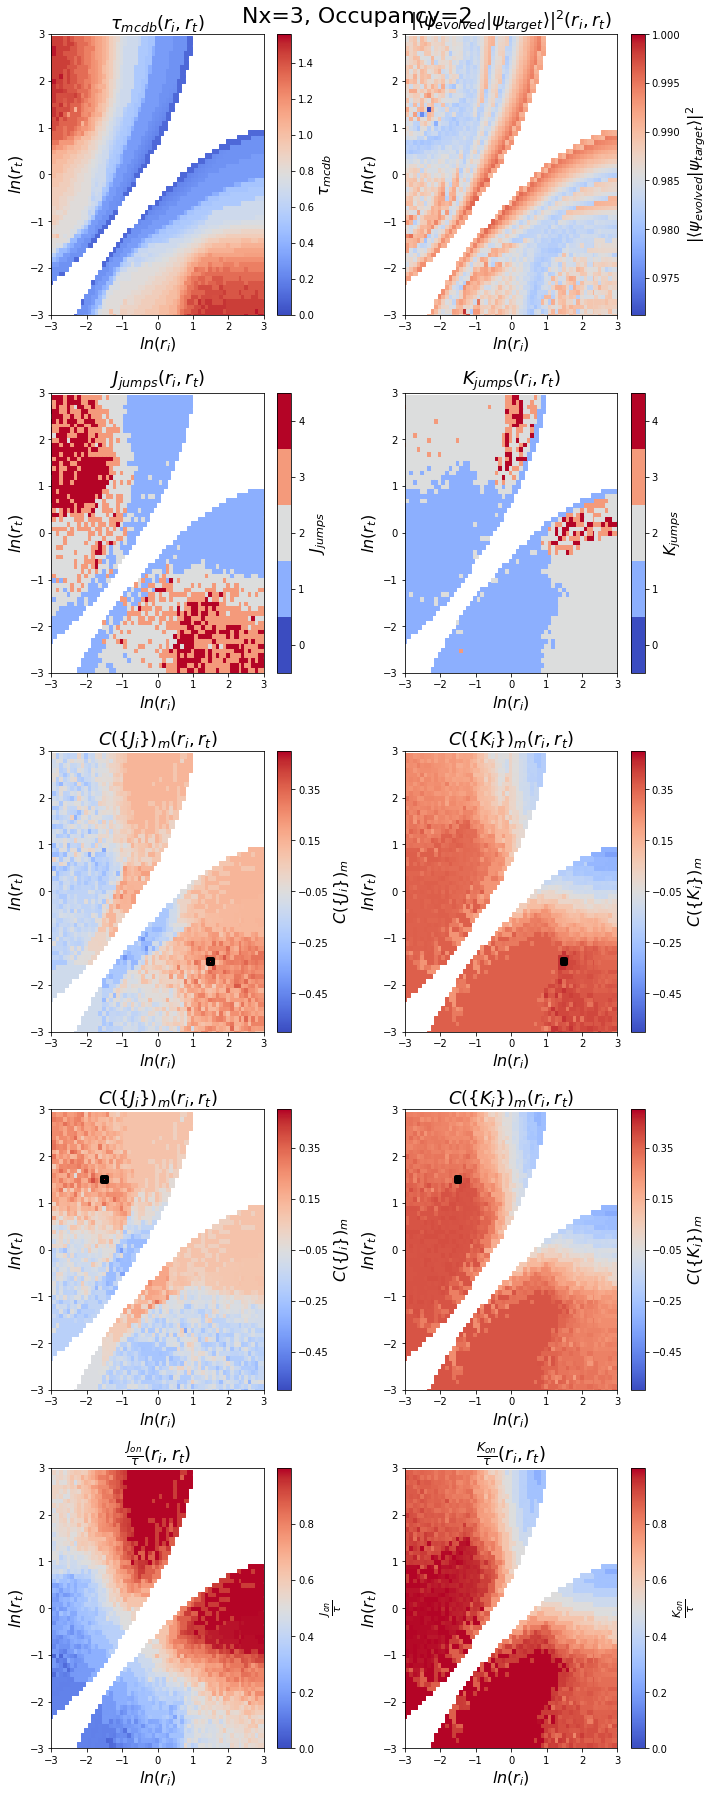

In [77]:
make_color_plots(data, save=False, tau_extrapolated = False, group_plot=True)

In [51]:
def make_3d_plots(data,dim,occ,r_var="ri",r_list=[-1.5,1.5],var="J",scatter=True, normalized = True):
    
    for dir_ in data:
        if(dir_.dim == dim and occ == dir_.occ): 
            d = dir_.mcdb_data
            break
    
    x,y,z,colors,jumps, taus = [],[],[],[],[],[]
    max_jumps = 14
    for ds in d:
        j = (ds.k_protocols_reduced[-1].copy()*(var=="K"))+(ds.j_protocols_reduced[-1].copy()*(var=="J"))
        tau,ri,rt = ds.tau_critical,math.log(ds.ji/ds.ki),math.log(ds.jt/ds.kt)
        if(tau != 0):
            jumps.append(np.linspace(len(j),len(j),max_jumps))
            j=list(np.array(j)/tau)
            while(len(j) <max_jumps): j.append(1.1)
            z.append(np.array(j)),y.append(np.linspace(rt,rt,max_jumps)),x.append(np.linspace(ri,ri,max_jumps)),taus.append(np.linspace(tau,tau,max_jumps))

    x,y,z,jumps,taus=np.array(x).T, np.array(y).T, np.array(z).T, np.array(jumps).T, np.array(taus).T
    r_list = [closest(list(set(x[0]*(r_var == "ri")+ y[0]*(r_var == "rt"))),r) for r in r_list]
    while(len(colors) <= max_jumps): colors = colors +  ["b","g","r","yellow"]

    r_rows = int(floor(len(r_list)/2))
    fig = plt.figure(figsize=(10,15+5*(r_rows)))
    gs = fig.add_gridspec(2+r_rows,2)

    ax = fig.add_subplot(gs[:2,:], projection='3d')
    ax.set_xlabel(r"$ln(r_i)$"),ax.set_ylabel(r"$ln(r_t)$"),ax.set_zlabel("Time of jump in "+str(var)) 
    ax.set_zlim(0,np.amax(taus)*(not normalized) + 1*normalized),ax.set_xlim(-3,3),ax.set_ylim(-3,3)
    
    for r in r_list:
        if(r_var == "ri"): line = [[r for x in range(10)],[3 for x in range(10)],list(np.linspace(0,np.amax(taus)*(not normalized) + 1*normalized,10))]
        if(r_var == "rt"): line = [[-3 for x in range(10)],[r for x in range(10)],list(np.linspace(0,np.amax(taus)*(not normalized) + 1*normalized,10))]
        ax.plot3D(line[0], line[1],line[2],color="black",lw=5,alpha=0.5)

    
    for num1 in range(max_jumps):
        xn,yn,zn,jumpsn,tausn = x[num1],y[num1],z[num1], jumps[num1],taus[num1]
        for num2 in range(max_jumps):
            index1 = np.where((xn>yn) & (zn<1) & (num2 == jumpsn))   
            x1,y1,z1,taus1 = xn[index1],yn[index1],zn[index1], tausn[index1]
            index2 = np.where((xn<yn) & (zn<1) & (num2 == jumpsn))   
            x2,y2,z2,taus2 = xn[index2],yn[index2],zn[index2], tausn[index2]
            if(not normalized): z1,z2 = z1*taus1,z2*taus2
            if(scatter):
                if(z1.size!=0): ax.scatter3D(x1, y1, z1,color=colors[num1],s=100)
                if(z2.size!=0): ax.scatter3D(x2, y2, z2,color=colors[num1],s=100)
            else:
                if(z1.size>2): ax.plot_trisurf(x1, y1, z1,color=colors[num1])
                if(z2.size>2): ax.plot_trisurf(x2, y2, z2,color=colors[num1])
    
    rowi,coli=2,0
    
    for r in r_list:
        ax = fig.add_subplot(gs[int(floor(rowi)),coli])
        plt.title(r"$ln(r_i)=$"*(r_var == "ri")+r"$ln(r_t)=$"*(r_var == "rt")+str(truncate(r,3)))
        plt.ylim(0,np.amax(taus)*(not normalized) + 1*normalized), plt.xlim(-3,3)
        plt.xlabel(r"$ln(r_t)$"*(r_var == "ri")+r"$ln(r_i)$"*(r_var == "rt")),plt.ylabel("Time of jump in "+str(var))
        for num1 in range(max_jumps):
            xn,yn,zn,jumpsn,tausn = x[num1],y[num1],z[num1], jumps[num1],taus[num1]
            if(r_var == "ri"): index = np.where((xn == r) & (zn<1))
            if(r_var == "rt"): index = np.where((yn == r) & (zn<1))
            xn,yn,zn,jumpsn,tausn = xn[index],yn[index],zn[index], jumpsn[index],tausn[index]
            if(not normalized): zn= zn*tausn
            ax.scatter(yn*(r_var == "ri")+xn*(r_var == "rt"),zn,c=colors[num1])
            
        rowi,coli = rowi+0.5,(coli +1)%2

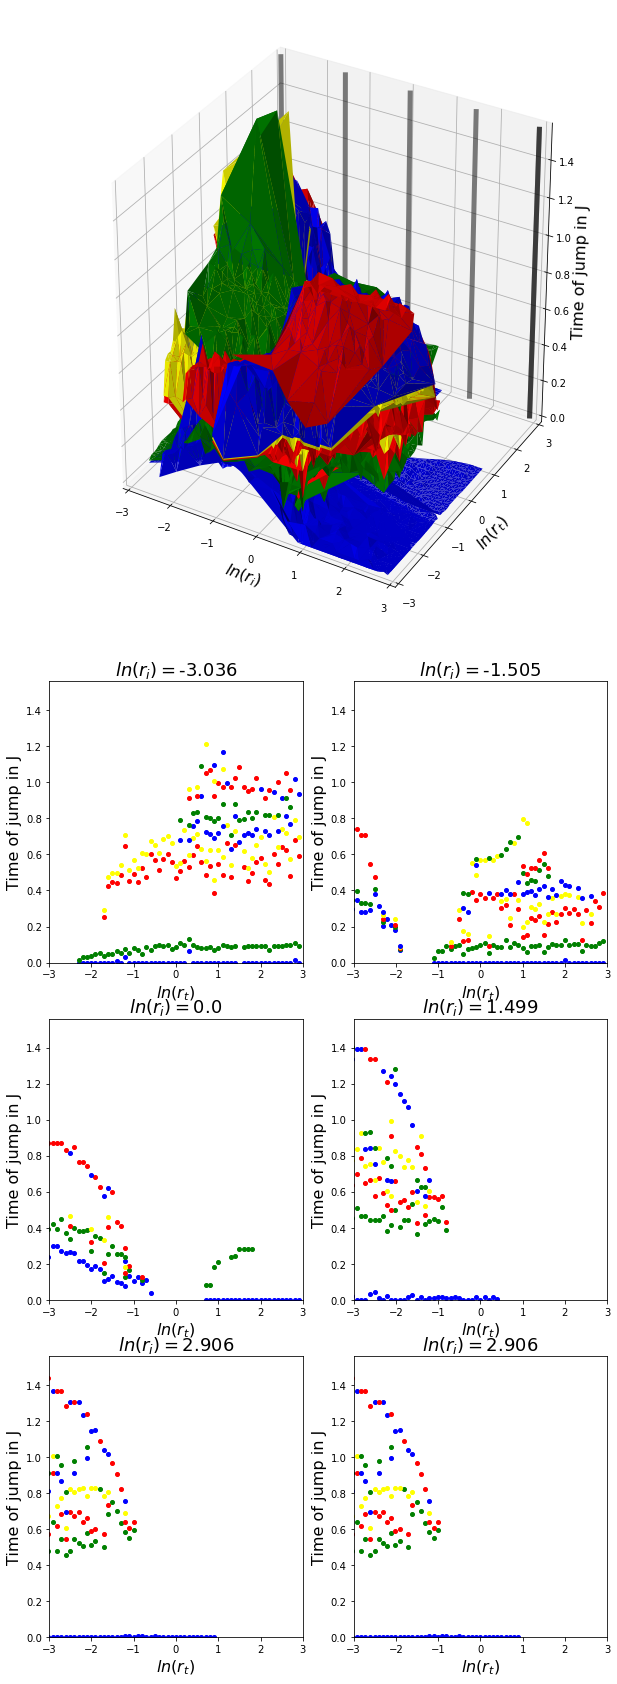

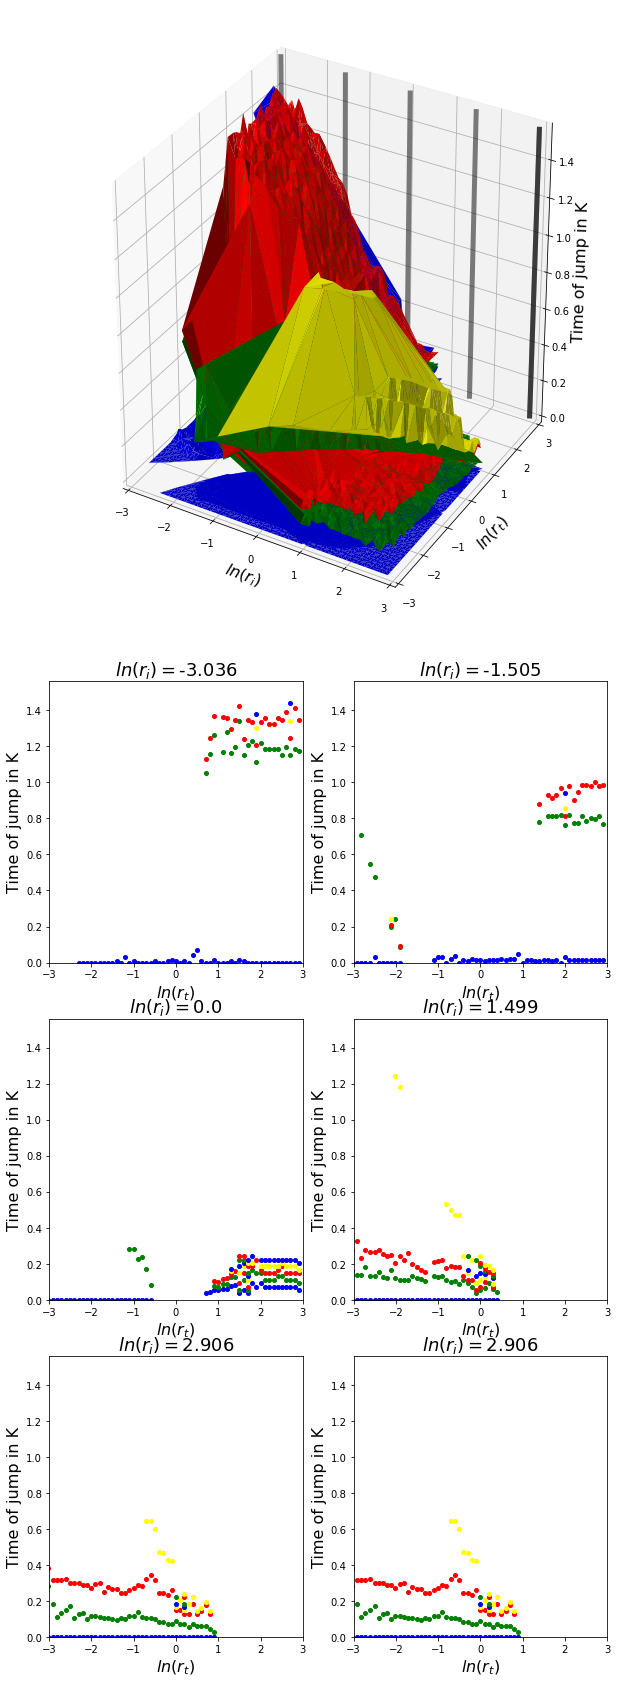

In [79]:
%matplotlib inline
dim, occ = 3,2
r_list = [-3,-1.5,0,1.5,3,3]
make_3d_plots(data,dim,occ,r_var="ri",r_list=r_list,var="J", scatter=False, normalized = False)
make_3d_plots(data,dim,occ,r_var="ri",r_list=r_list,var="K", scatter=False, normalized = False)

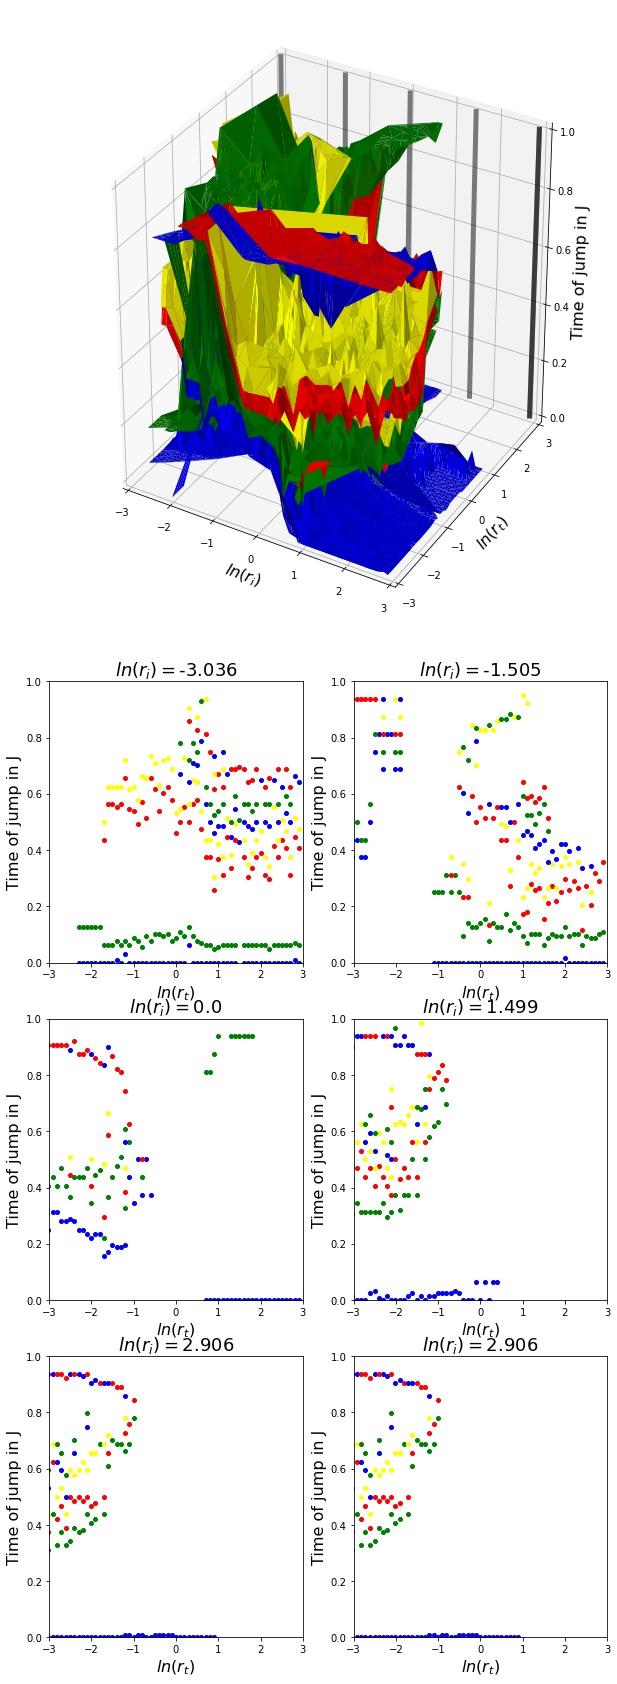

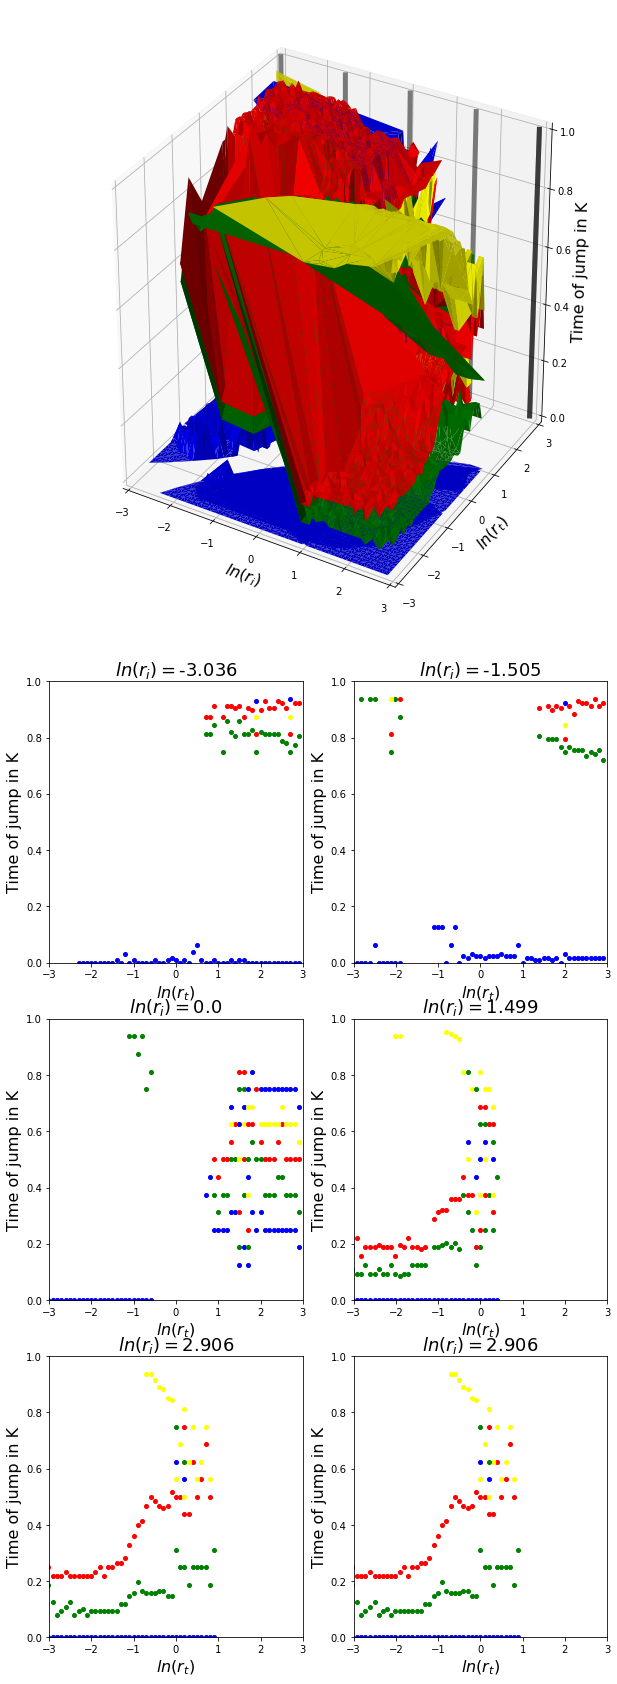

In [100]:
%matplotlib inline
dim, occ = 3,2
r_list = [-3,-1.5,0,1.5,3,3]
make_3d_plots(data,dim,occ,r_var="ri",r_list=r_list,var="J", scatter=False, normalized = True)
make_3d_plots(data,dim,occ,r_var="ri",r_list=r_list,var="K", scatter=False, normalized = True)

<ipython-input-98-ef67170936a2>:46: RuntimeWarning: invalid value encountered in log
  if(alpha != 0): plt.plot(np.log(abs(x-r0)), np.log(powerlaw(x,r0,c, alpha)), label = r"$\alpha=$"+str(truncate(alpha,3))+"\n"+r"$\chi^2=$"+str(truncate(chi_sq,4)))


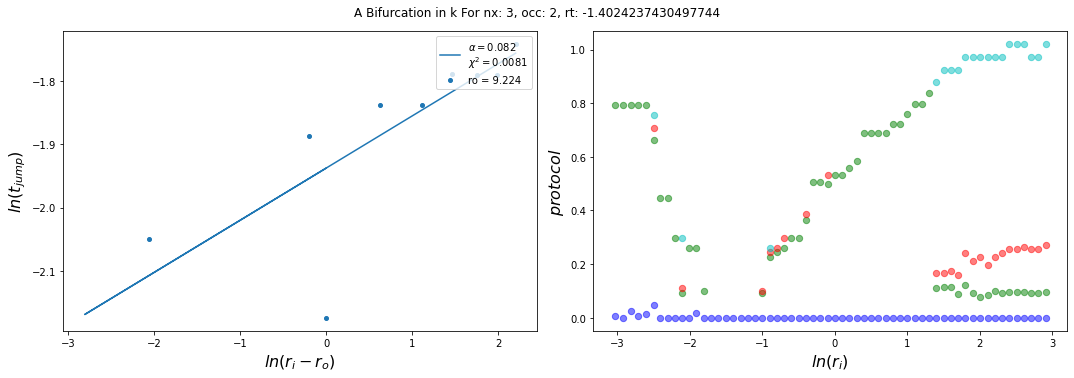

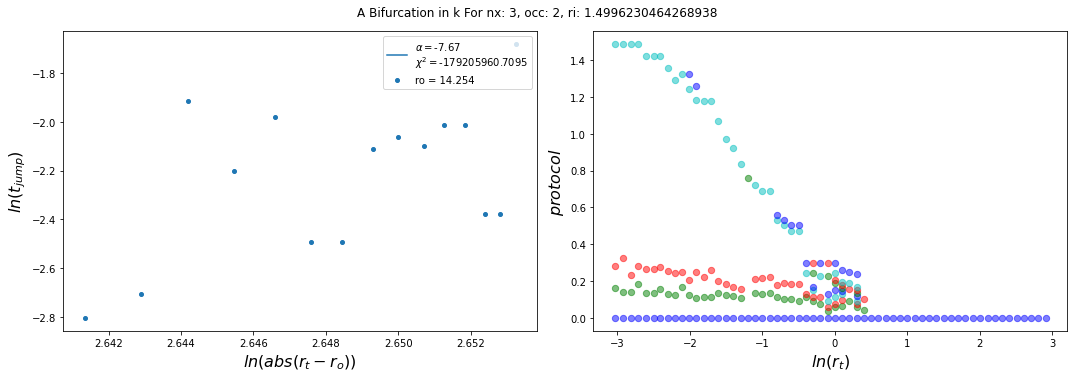

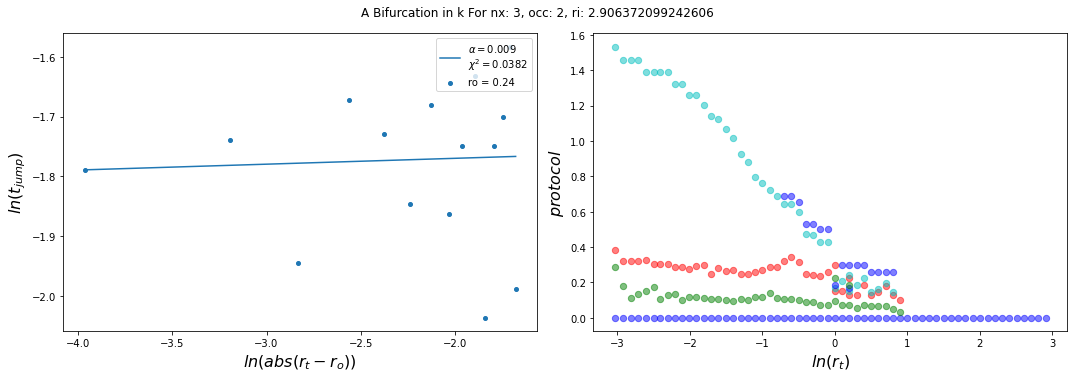

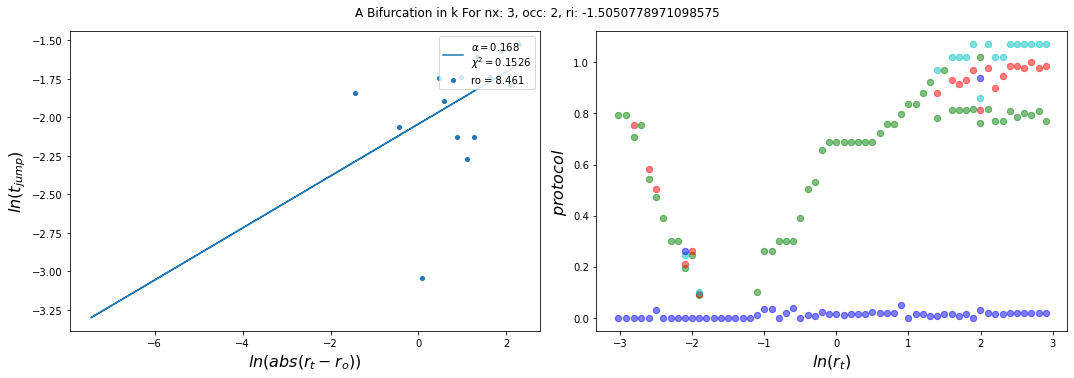

In [101]:
%matplotlib inline
TAU_NORMALIZING = False
fit_powerlaw(data,3,2,2,3,2,3, "k", r_val=-1.402,r_var="rt")
fit_powerlaw(data,3,2,2,3,-3,-1.5, "k", r_val=1.499,r_var="ri")
fit_powerlaw(data,3,2,2,3,-3,-1.5, "k", r_val=2.906,r_var="ri")
fit_powerlaw(data,3,2,2,3,1.5,3, "k", r_val=-1.505,r_var="ri",t1=0.5,t2=1)


# Searching for some sort of universality in the protocol bifurcations

In [84]:
def powerlaw(r,r0,c, alpha):
    return c*(abs(r-r0))**alpha

In [98]:
def fit_powerlaw(data,nx,occ,j1_num,j2_num,rmin,rmax, var, r_val=0,r_var="ri",t1=0,t2=1):
    for x in range(len(data)):
        if(data[x].dim == nx and data[x].occ == occ):
            break
            
    ratios = [math.log(ds.ji/ds.ki*(r_var == "ri")+ ds.jt/ds.kt*(r_var == "rt")) for ds in data[x].mcdb_data]  
    r_val = closest(ratios,r_val)
    
    if(r_var=="ri"): powerlaw_data_temp = get_data_sets(data[x].mcdb_data, ri=r_val)
    if(r_var=="rt"): powerlaw_data_temp = get_data_sets(data[x].mcdb_data, rt=r_val)

    all_ratios, ps,powerlaw_data = [],[],[]
    for data_set in powerlaw_data_temp:
        ri,rt = math.log(data_set.ji/data_set.ki),math.log(data_set.jt/data_set.kt)
        if(rmin< ri*(r_var == "rt")+rt*(r_var == "ri") < rmax): powerlaw_data.append(data_set)
        all_ratios.append(data_set.jt/data_set.kt*(r_var == "ri")+data_set.ji/data_set.ki*(r_var == "rt"))
        t=1
        if(TAU_NORMALIZING): t = data_set.tau_critical
        ps.append(np.array((var=="j")*data_set.j_protocols_reduced[-1] + (var=="k")*data_set.k_protocols_reduced[-1])/t)
        
    ratios,widths = [],[]
    for data_set in powerlaw_data:
        p = (var=="j")*data_set.j_protocols_reduced[-1] + (var=="k")*data_set.k_protocols_reduced[-1]
        if(len(p)>= max(j1_num,j2_num)):
            if((p[j1_num-1]/data_set.tau_critical>t1) and (p[j2_num-1]/data_set.tau_critical<t2)):
                t = 1
                if(TAU_NORMALIZING): t = data_set.tau_critical
                ratios.append(data_set.jt/data_set.kt*(r_var == "ri")+data_set.ji/data_set.ki*(r_var == "rt"))
                widths.append((p[2]-p[1])/t)
    try:       
        popt, pcov = curve_fit(f=powerlaw, xdata=ratios, ydata=widths,maxfev = 50000,bounds=([0,-np.inf,-np.inf],[20,np.inf,np.inf]))#p0=[1,1,0.2], bounds = ([0,-np.inf,0],[20,np.inf,np.inf]))
        r0,c,alpha = popt[0], popt[1], popt[2]
        chi_sq = calc_chi_sq(widths,powerlaw(ratios, r0, c, alpha))
    except:
        print("Unable to fit bifurcation in " +str(var)+ " for nx: "+str(nx)+", occ: "+str(occ)+", "+r_var+": "+str(r_val))
        r0,c,alpha, chi_sq = 0,1,0,0

    x = (np.linspace(min(ratios),max(ratios), 20))
    fig = plt.figure(figsize=(15,5))
    plt.suptitle("A Bifurcation in " +str(var)+ " For nx: "+str(nx)+", occ: "+str(occ)+", "+r_var+": "+str(r_val),y=1.04)
    
    
    fig.add_subplot(1,2,1)
    plt.xlabel(r"$ln(abs(r_t-r_o))$"*(r_var == "ri")+r"$ln(r_i-r_o)$"*(r_var == "rt")), plt.ylabel(r"$ln(t_{jump})$")
    plt.scatter(np.log(abs(np.array(ratios)-r0)),np.log(widths), label = "ro = "+str(truncate(r0,3)))
    if(alpha != 0): plt.plot(np.log(abs(x-r0)), np.log(powerlaw(x,r0,c, alpha)), label = r"$\alpha=$"+str(truncate(alpha,3))+"\n"+r"$\chi^2=$"+str(truncate(chi_sq,4)))
    plt.legend(loc="upper right")
    
    fig.add_subplot(1,2,2)
    colors = ["b","g","r","c","b","g","r","c","b","g","r","c","b","g","r","c","b","g","r","c","b","g","r","c",]
    plt.xlabel(r"$ln(r_t)$"*(r_var == "ri")+r"$ln(r_i)$"*(r_var == "rt")),plt.ylabel(r"$protocol$")
    
    x_vals = []         
    for x in range(len(ps)): 
        x_vals.append(np.linspace(np.log(all_ratios[x]),np.log(all_ratios[x]), np.size(ps[x])))

    for x in range(len(ps)):
        for y in range(len(ps[x])):
            plt.scatter(x_vals[x][y],ps[x][y],c=colors[y], s=40, alpha = 0.5)
 
    fig.tight_layout(pad=1.0)  
    dir_ = "figures/bifurcation_fits"
    if(TAU_NORMALIZING): dir_ = dir_ + "_tau_normalized"
    plt.savefig(dir_+"/a_bifurcation_in_" +str(var)+ "_for_nx="+str(nx)+"_occ="+str(occ)+"_"+r_var+"="+str(r_val)+".pdf")

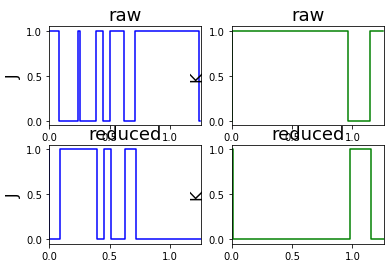

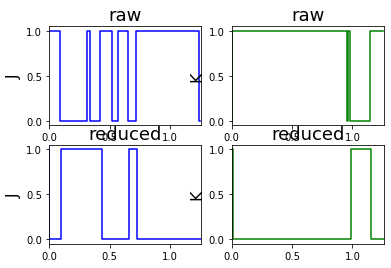

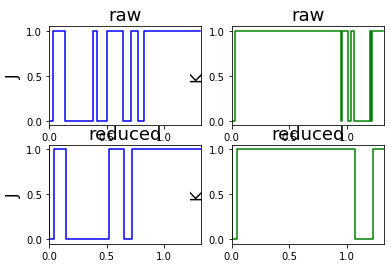

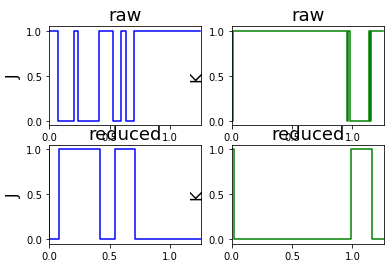

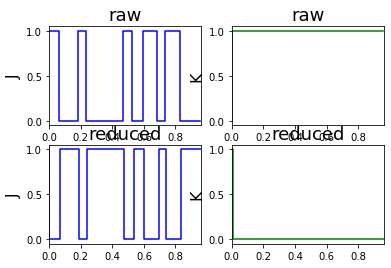

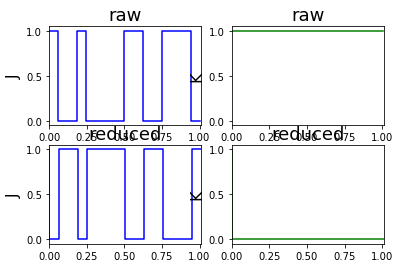

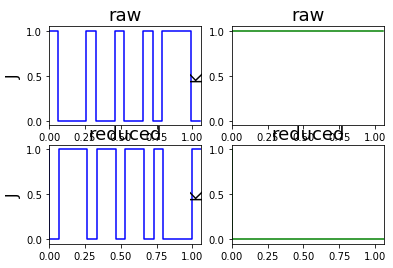

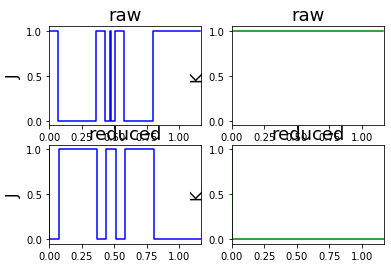

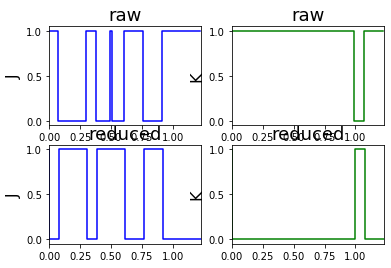

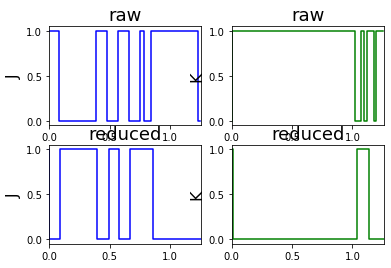

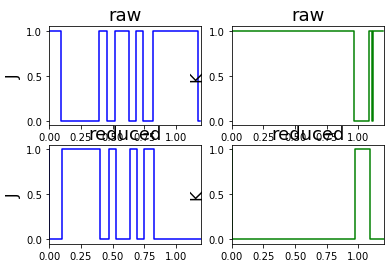

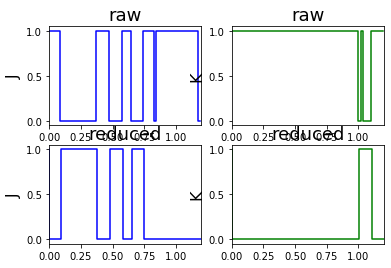

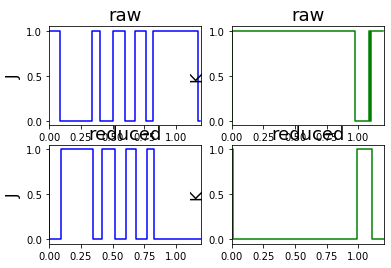

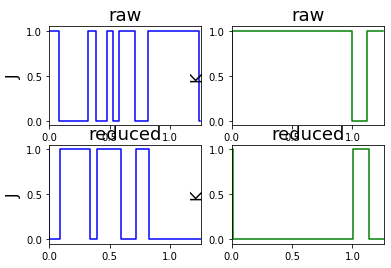

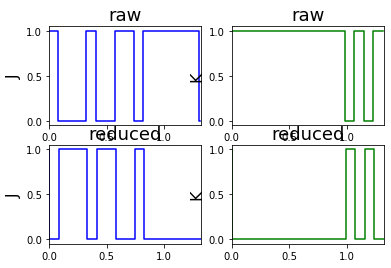

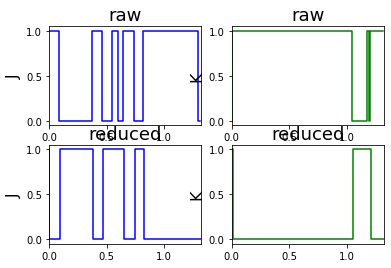

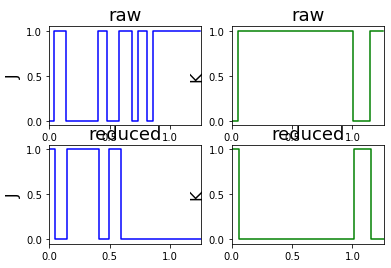

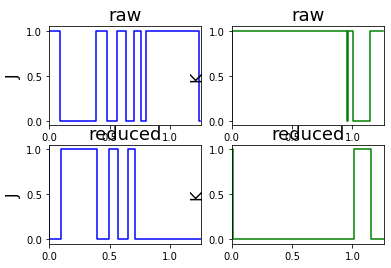

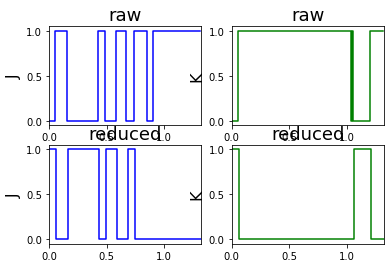

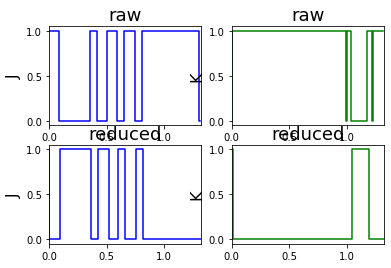

In [83]:
ri,rt = [math.log(ds.ji/ds.ki) for ds in data[0].mcdb_data].copy(),[math.log(ds.jt/ds.kt) for ds in data[0].mcdb_data].copy()
sets= get_data_sets(data[0].mcdb_data, ri=closest(ri,-2))[40:]#, rt = closest(ri,2.806))
nums = [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,]
for ds in sets:
    
    j,j2,k,k2= ds.j_protocols[-1],ds.j_protocols_reduced[-1],ds.k_protocols[-1],ds.k_protocols_reduced[-1]
    ts = ds.tau_array[-1]/ds.total_steps_array[-1]
    fig = plt.figure()
    fig.add_subplot(2,2,1)
    step_plot(np.arange(0,ds.tau_critical,ts), j, 'raw', "",'blue' ,'J', ds.tau_critical, 0, 1.05, -.05)
    fig.add_subplot(2,2,2)
    step_plot(np.arange(0,ds.tau_critical,ts), k, 'raw', "",'green' ,'K', ds.tau_critical, 0, 1.05, -.05)
    fig.add_subplot(2,2,3)
    step_plot(j2, nums[:len(j2)], 'reduced', "",'blue' ,'J', ds.tau_critical, 0, 1.05, -.05)
    fig.add_subplot(2,2,4)
    step_plot(k2, nums[:len(k2)], 'reduced', "",'green' ,'K', ds.tau_critical, 0, 1.05, -.05)


# Looking at protocols

# Attempting to find a fit that  matches the total time in ri/rt space

In [20]:
def func(rs, a,r0):#,ri0,rt0):
    ri,rt = rs[0],rs[1]
    dif1 = abs(ri-0)
    dif2 = abs(rt-0)
    return a*(abs(np.log(dif1/dif2-r0)))

N,a = [],[]
for dir_ in data:
    N.append(choose(dir_.dim*dir_.dim, dir_.occ))
    taus = [ds.tau_critical for ds in dir_.mcdb_data]
    ris = np.array([ds.ji/ds.ki for ds in dir_.mcdb_data])
    rts = np.array([ds.jt/ds.kt for ds in dir_.mcdb_data])

    params, pcov = optimize.curve_fit(func, [ris,rts], taus, maxfev = 10000)
    a.append(params[0])
    plt.figure()
    plt.scatter(np.log(ris),np.log(rts),c=func([ris,rts],params[0],params[1]),cmap=cmap, marker = "s", s=300)
    plt.colorbar()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

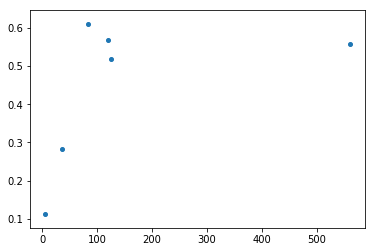

In [17]:
plt.scatter(N,a)

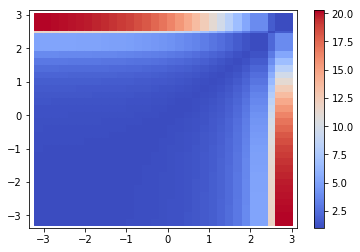

In [47]:

def func(rs):#,ri0,rt0):
    ri,rt = rs[0],rs[1]
    a=1
    b=1.2
    c=0
    dif1 = abs(ri-c)
    dif2 = abs(rt-c)
    #return a*(abs(np.log(dif1/dif2))) + 
    return b**(abs(dif1-dif2))

dir_ = data[0]
ris = np.array([ds.ji/ds.ki for ds in dir_.mcdb_data])
rts = np.array([ds.jt/ds.kt for ds in dir_.mcdb_data])

plt.figure()
plt.scatter(np.log(ris),np.log(rts),c=func([ris,rts]),cmap=cmap, marker = "s", s=300)
plt.colorbar()

# Misc Figures for Paper 

## Comparing MC to adiabatic

In [50]:
def distance_vs_tau(data,dim,occ,ji,ki,jt,kt):
    for dir_ in data:
        if(dir_.dim ==dim and dir_.occ ==occ): 
            break
            
    mcbf_set = get_data_sets(dir_.mcbf_data, ji=ji, ki=ki, jt=jt, kt=kt)[0]
    mcdb_set = get_data_sets(dir_.mcdb_data, ji=ji, ki=ki, jt=jt, kt=kt)[0]
    mcbb_set = get_data_sets(dir_.mcbb_data, ji=ji, ki=ki, jt=jt, kt=kt)[0]
    adia_set = get_data_sets(dir_.adia_data, ji=ji, ki=ki, jt=jt, kt=kt)[0]
    
    plt.figure(figsize=(10,10))
    plt.title(r"$N_{lattice}$ = "+str(dir_.dim)+"    Occupants = "+str(dir_.occ)+r"    $j_{initial}$ = "+str(ji)+ r"    $k_{initial}$ = "+str(ki)+r"    $j_{target}$ = "+str(jt)+ r"    $k_{target}$ = "+str(kt))
    plt.xlabel(r"$\tau$"), plt.ylabel(r"$D(\psi(t))$")
    plt.xlim(0.1,0.7),plt.ylim(0,1)
    lw = 5
    plt.plot(mcbf_set.tau_array,mcbf_set.distance_array, label = "MCBF", lw=lw)
#     plt.plot(mcdb_set.tau_array,mcdb_set.distance_array, label = "MCDB", lw=lw, linestyle='-.',alpha=0.5)
#     plt.plot(mcbb_set.tau_array,mcbb_set.distance_array, label = "MCBB", lw=lw, linestyle=':',alpha=0.5)
    plt.plot(adia_set.tau_array,adia_set.distance_array, label = "ADIA", lw=lw)
    plt.legend(loc="upper right")
    plt.savefig("figures/distance_vs_tau.pdf")
    
    
    fig = plt.figure(figsize=(10,5))
    fig.add_subplot(2,2, 1)
    plt.title("ADIABATIC")
    plt.ylabel("J")
    plt.plot(np.linspace(0,adia_set.tau_critical,100), np.linspace(ji,jt,100),color="blue")
    fig.add_subplot(2,2, 3)
    plt.ylabel("K"),plt.xlabel("Time")
    plt.plot(np.linspace(0,adia_set.tau_critical,100), np.linspace(ki,kt,100),color="green")
        
     
    j,k = mcbf_set.j_protocols[-1].copy(), mcbf_set.k_protocols[-1].copy()
    fig.add_subplot(2,2, 2)
    step_plot(np.arange(0,mcbf_set.tau_critical,mcbf_set.time_step_array[-1])[:-1], j, 'MCBF', "",'blue' ,'', mcbf_set.tau_critical, 0, 1.05, -.05)
    fig.add_subplot(2,2, 4)
    step_plot(np.arange(0,mcbf_set.tau_critical,mcbf_set.time_step_array[-1])[:-1], k, '', "",'green' ,'', mcbf_set.tau_critical, 0, 1.05, -.05)


    plt.savefig("figures/protocol_comparisons.pdf")
    
    
    
    
    plt.figure(figsize=(10,10))
    plt.title(r"$N_{lattice}$ = "+str(dir_.dim)+"    Occupants = "+str(dir_.occ)+r"    $j_{initial}$ = "+str(ji)+ r"    $k_{initial}$ = "+str(ki)+r"    $j_{target}$ = "+str(jt)+ r"    $k_{target}$ = "+str(kt))
    plt.xlabel(r"$\tau$"), plt.ylabel(r"$D(\psi(t))$")
    plt.xlim(0.3,0.45),plt.ylim(0,0.2)
    lw = 0.5  
    plt.plot(mcbf_set.tau_array,mcbf_set.distance_array, label = "MCBF", lw=lw)
    plt.plot(mcdb_set.tau_array,mcdb_set.distance_array, label = "MCDB", lw=lw)#, linestyle='-.',alpha=0.5)
    plt.plot(mcbb_set.tau_array,mcbb_set.distance_array, label = "MCBB", lw=lw)#, linestyle=':',alpha=0.5)
    plt.savefig("figures/mc_distance_comparisons.pdf")

    
    
    
    fig = plt.figure(figsize=(15,5))
    j,k = mcbf_set.j_protocols[-1].copy(), mcbf_set.k_protocols[-1].copy()
    fig.add_subplot(2,3, 1)
    step_plot(np.arange(0,mcbf_set.tau_critical,mcbf_set.time_step_array[-1])[:-1], j, 'MCBF', "",'blue' ,'', mcbf_set.tau_critical, 0, 1.05, -.05)
    fig.add_subplot(2,3, 4)
    step_plot(np.arange(0,mcbf_set.tau_critical,mcbf_set.time_step_array[-1])[:-1], k, '', "",'green' ,'', mcbf_set.tau_critical, 0, 1.05, -.05)
    jkb_vals = [0,1,0,1,0,1,0,1,0,1,0,1,0]
    j,k = mcbb_set.j_protocols_reduced[-1].copy(), mcbb_set.k_protocols_reduced[-1].copy()
    fig.add_subplot(2,3, 2)
    step_plot(j, jkb_vals[:np.size(j)], 'MCBB', "",'blue' ,'', mcbb_set.tau_critical, 0, 1.05, -.05)
    fig.add_subplot(2,3, 5)
    step_plot(k, jkb_vals[:np.size(k)], '', "",'green' ,'', mcbb_set.tau_critical, 0, 1.05, -.05)
    j,k = mcdb_set.j_protocols_reduced[-1].copy(), mcdb_set.k_protocols_reduced[-1].copy()
    fig.add_subplot(2,3, 3)
    step_plot(j, jkb_vals[:np.size(j)], 'MCDB', "",'blue' ,'', mcdb_set.tau_critical, 0, 1.05, -.05)
    fig.add_subplot(2,3, 6)
    step_plot(k, jkb_vals[:np.size(k)], '', "",'green' ,'', mcdb_set.tau_critical, 0, 1.05, -.05)
    plt.savefig("figures/mc_protocol_comparisons.pdf")

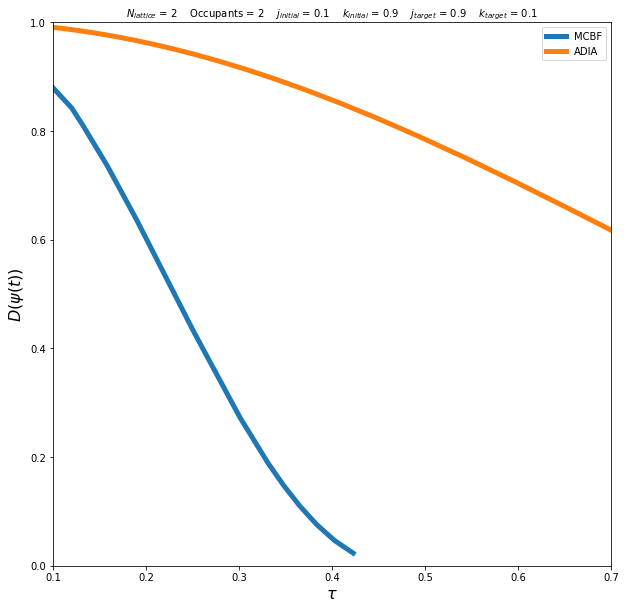

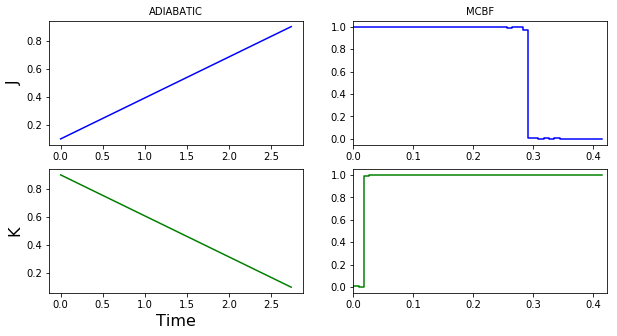

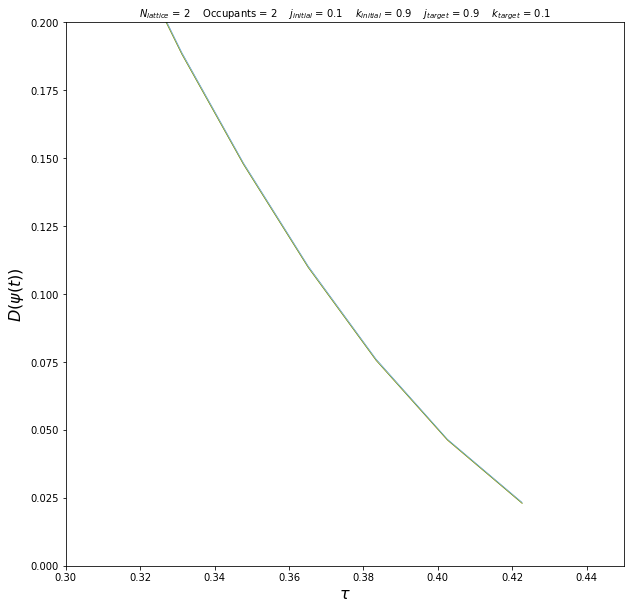

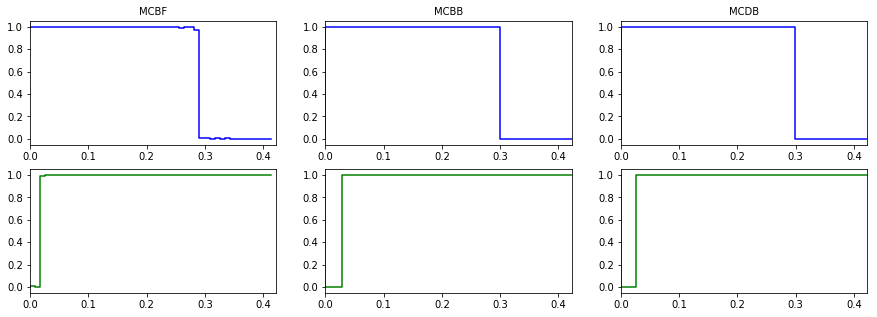

In [51]:
distance_vs_tau(data,2,2,0.1,0.9,0.9,0.1)

In [141]:
def protocol_group_plot_single(data,dim,occ,ji,ki,jt,kt,save):
    for dir_ in data:
        if(dir_.dim ==dim and dir_.occ ==occ): 
            break
            
    data_set = get_data_sets(dir_.mcdb_data, ji=ji, ki=ki, jt=jt, kt=kt)[0]

    if(data_set.skip):
        print("No data for group plot comparison, going to the next")
        return

    fig = plt.figure(figsize=(15,15))
    fig.suptitle(r"$N_{grid}$ = "+str(dir_.dim)+"    Occupants = "+str(dir_.occ)+r"    $j_{initial}$ = "+str(ji)+ r"    $k_{initial}$ = "+str(ki)+r"    $j_{target}$ = "+str(jt)+ r"    $k_{target}$ = "+str(kt))
   
    taus= data_set.tau_array
    fig.add_subplot(2, 2, 1)
    plt.scatter(taus,data_set.distance_array)
    #plt.scatter(data_set.tau_extrapolated,data_set.ground_e)
    plt.scatter(data_set.tau_extrapolated,0)
    
    j,k = data_set.j_protocols_reduced,data_set.k_protocols_reduced
    fig.add_subplot(2, 2, 2)
    for y in range(len(taus)):
        plt.scatter(np.linspace(taus[y],taus[y],len(j[y])),j[y],c="green")
        plt.scatter(np.linspace(taus[y],taus[y],len(k[y])),k[y],c="blue")

    
    jkb_vals = [0,1,0,1,0,1,0,1,0,1,0,1,0]
    j,k = j[-1].copy(), k[-1].copy()
    fig.add_subplot(2, 2, 3)
    step_plot(j, jkb_vals[:np.size(j)], '', "Time",'blue' ,'j', data_set.tau_critical, 0, 1.05, -.05)
    fig.add_subplot(2, 2, 4)
    step_plot(k, jkb_vals[:np.size(k)], '', "Time",'limegreen' ,'k', data_set.tau_critical, 0, 1.05, -.05)

    if(save): save_plot(str(dir_.dim)+"x"+str(dir_.dim)+"/"+str(dir_.occ)+"_occupants/", "gp_ji=" + str(ji) + "_ki=" +str(ki)+"jt=" + str(jt) + "_kt=" +str(kt)) 
    plt.show()

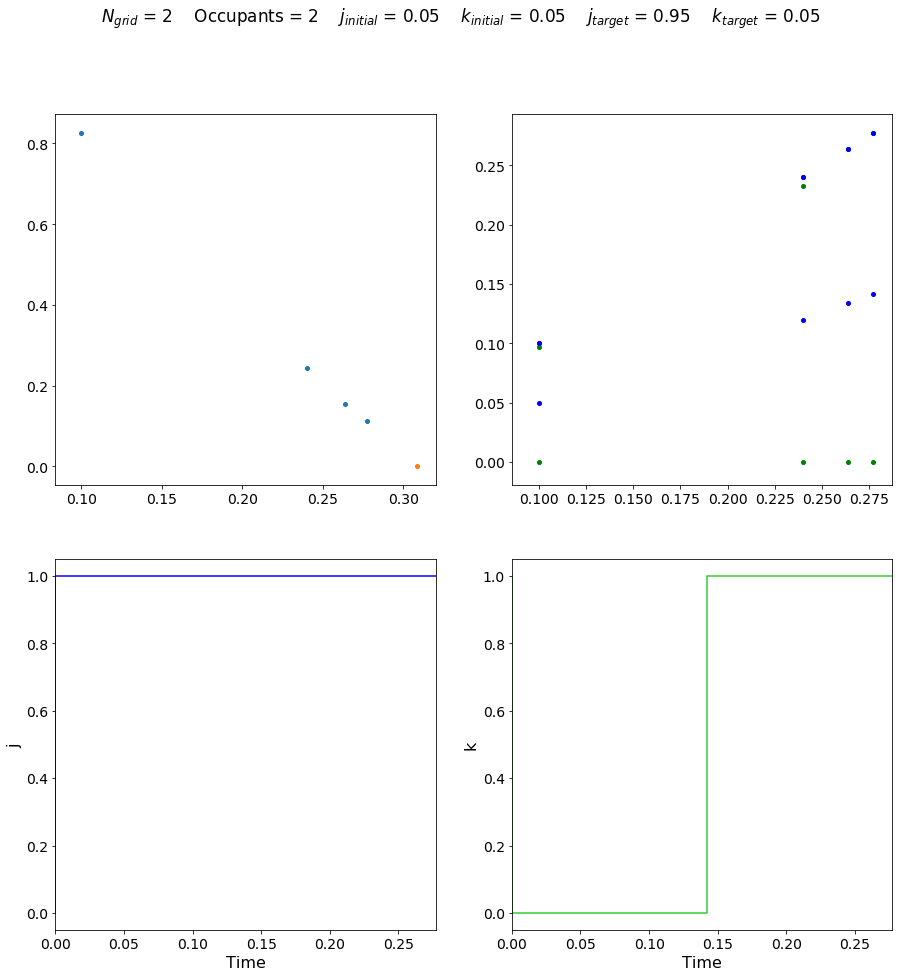

In [164]:
dim,occ,ji,ki,jt,kt = 2,2,0.05,0.05,0.95,0.05
protocol_group_plot_single(data,dim,occ,ji,ki,jt,kt,save)


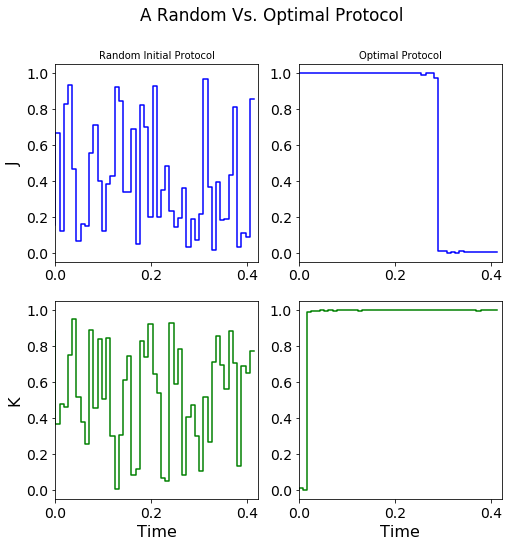

In [177]:
mcbf_set = get_data_sets(data[0].mcbf_data, ji=0.1, ki=0.9, jt=0.9, kt=0.1)[0]

fig = plt.figure(figsize=(8,8))
fig.suptitle("A Random Vs. Optimal Protocol")


fig.add_subplot(2,2, 1)
step_plot(np.arange(0,mcbf_set.tau_critical,mcbf_set.time_step_array[-1])[:-1], np.random.rand(mcbf_set.total_steps_array[-1]), 'Random Initial Protocol', "",'blue' ,'J', mcbf_set.tau_critical, 0, 1.05, -.05)
fig.add_subplot(2,2, 3)
step_plot(np.arange(0,mcbf_set.tau_critical,mcbf_set.time_step_array[-1])[:-1], np.random.rand(mcbf_set.total_steps_array[-1]), '', "Time",'green' ,'K', mcbf_set.tau_critical, 0, 1.05, -.05)





j,k = mcbf_set.j_protocols[-1].copy(),mcbf_set.k_protocols[-1].copy()
fig.add_subplot(2,2, 2)
step_plot(np.arange(0,mcbf_set.tau_critical,mcbf_set.time_step_array[-1])[:-1], j, 'Optimal Protocol', "",'blue' ,'', mcbf_set.tau_critical, 0, 1.05, -.05)
fig.add_subplot(2,2, 4)
step_plot(np.arange(0,mcbf_set.tau_critical,mcbf_set.time_step_array[-1])[:-1], k, '', "Time",'green' ,'', mcbf_set.tau_critical, 0, 1.05, -.05)
plt.savefig("figures/mcbf_comp.pdf")

## Comparing total time for adiabatic and mcdb 

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


<Figure size 720x720 with 0 Axes>

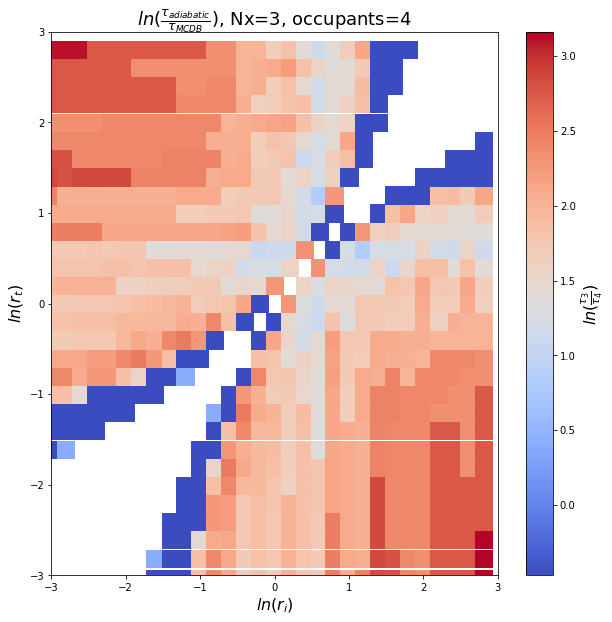

In [84]:
fig = plt.figure(figsize=(10,10))
dir_ = data[3]
tau = [ds.tau_critical for ds in dir_.mcdb_data]
tau_ex = [ds.tau_extrapolated for ds in dir_.mcdb_data]
tau_adia = [ds.tau_critical for ds in dir_.adia_data]
tau_adia_ex = [ds.tau_extrapolated for ds in dir_.adia_data]
skip_list1 = [ds.skip for ds in dir_.mcdb_data]
skip_list2 = [ds.skip for ds in dir_.adia_data]
  
tau_ratio, tau_ratio_ex,skip_list = [],[],[]
for x in range(len(tau_4_occ)):
    skippy = skip_list1[x] or skip_list2[x]
    if(not skippy):
        tau_ratio.append(tau_adia[x]/tau[x])
        tau_ratio_ex.append(tau_adia_ex[x]/tau_ex[x])
    else:
        tau_ratio.append(0)
        tau_ratio_ex.append(0)
    skip_list.append(skippy)

s = [0*(skip) + 300*(not skip) for skip in skip_list]
    
fig = plt.figure(figsize=(10,10))
plt.title(r"$ln(\frac{\tau_{adiabatic}}{\tau_{MCDB}})$, Nx="+str(dir_.dim) + ", occupants="+str(dir_.occ))
plt.ylabel(r"$ln(r_t)$"), plt.xlabel(r"$ln(r_i)$"), plt.ylim(-3,3), plt.xlim(-3,3)
plt.scatter(ris,rts,cmap=cmap, marker = "s", s=s, c= np.log((tau_ratio)))
plt.colorbar(label  = r"$ln(\frac{\tau_{3}}{\tau_4})$")
plt.savefig("figures/adia_vs_opt_tau.pdf")

## Ratio of tau for 3x3-4:3x3-3

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


<Figure size 720x720 with 0 Axes>

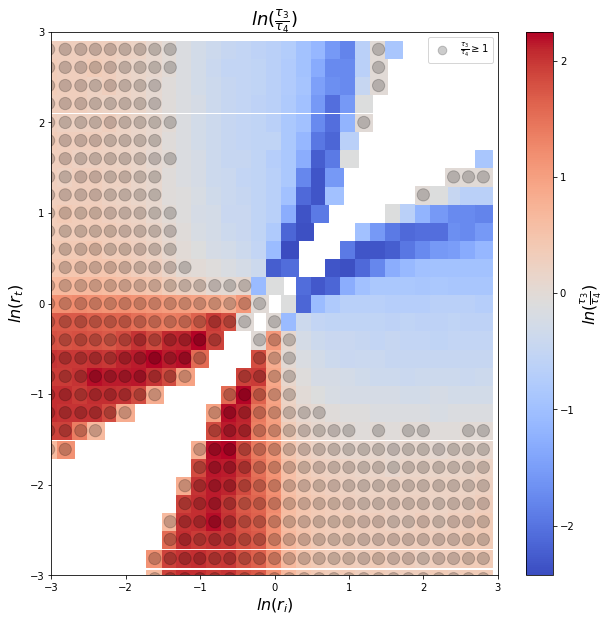

In [73]:
occ_3_dir_mcdb = data[2].mcdb_data
occ_4_dir_mcdb = data[3].mcdb_data

fig = plt.figure(figsize=(10,10))
tau_3_occ = [ds.tau_critical for ds in occ_3_dir_mcdb]
tau_3_occ_ex = [ds.tau_extrapolated for ds in occ_3_dir_mcdb]
tau_4_occ = [ds.tau_critical for ds in occ_4_dir_mcdb]
tau_4_occ_ex = [ds.tau_extrapolated for ds in occ_4_dir_mcdb]
ri, rt = [math.log(ds.ji/ds.ki) for ds in occ_3_dir_mcdb],[math.log(ds.jt/ds.kt) for ds in occ_3_dir_mcdb]
skip_list1 = [ds.skip for ds in occ_3_dir_mcdb]
skip_list2 = [ds.skip for ds in occ_4_dir_mcdb]

if(len(tau_3_occ) != len(tau_4_occ)): print("ERRORORORORORO")
  
tau_ratio, tau_ratio_ex,skip_list = [],[],[]
for x in range(len(tau_4_occ)):
    skippy = skip_list1[x] or skip_list2[x]
    if(not skippy):
        tau_ratio.append(tau_3_occ[x]/tau_4_occ[x])
        tau_ratio_ex.append(tau_3_occ_ex[x]/tau_4_occ_ex[x])
    else:
        tau_ratio.append(0)
        tau_ratio_ex.append(0)
    skip_list.append(skippy)

s1 = [0*(skip) + 150*(not skip and (tr >= 1)) for skip,tr in zip(skip_list,tau_ratio)]
s = [0*(skip) + 300*(not skip) for skip in skip_list]
    
fig = plt.figure(figsize=(10,10))
plt.title(r"$ln(\frac{\tau_{3}}{\tau_4})$")
plt.ylabel(r"$ln(r_t)$"), plt.xlabel(r"$ln(r_i)$"), plt.ylim(-3,3), plt.xlim(-3,3)
plt.scatter(ris,rts,cmap=cmap, marker = "s", s=s, c= np.log((tau_ratio)))
plt.colorbar(label  = r"$ln(\frac{\tau_{3}}{\tau_4})$")
plt.scatter(ris,rts,c="black", alpha = 0.2,s=s1, label=r"$\frac{\tau_{3}}{\tau_4} \geq 1$")
plt.legend(loc="upper right")
plt.savefig("figures/tau_ratios_new.pdf")



# s1 = [0*(skip) + 150*(not skip and (tr >= 1)) for skip,tr in zip(skip_list,tau_ratio_ex)]
# s = [0*(skip) + 300*(not skip) for skip in skip_list]
    
# fig = plt.figure(figsize=(10,10))
# plt.title(r"$ln(\frac{\tau_{3}}{\tau_4})$")
# plt.ylabel(r"$ln(r_t)$"), plt.xlabel(r"$ln(r_i)$"), plt.ylim(-3,3), plt.xlim(-3,3)
# plt.scatter(ris,rts,cmap=cmap, marker = "s", s=s, c= np.log((tau_ratio_ex)))
# plt.colorbar(label  = r"$ln(\frac{\tau_{3}}{\tau_4})$")
# plt.scatter(ris,rts,c="black", alpha = 0.2,s=s1, label=r"$\frac{\tau_{3}}{\tau_4} \geq 1$")
# plt.legend(loc="upper right")
# #plt.savefig("figures/tau_ratios_new.pdf")

## Looking for scaling across different system sizes

In [30]:
class avg_data_per_init:
    
    def __init__(self, ji,ki,j_jumps,k_jumps,j_comps, k_comps,taus, size):
        self.ji          = ji
        self.ki          = ki
        
        self.taus        = taus
        self.tau_avg     = np.mean(taus)
        self.tau_std     = np.std(taus)
        
        self.j_jumps     = j_jumps
        self.j_jumps_avg = np.mean(j_jumps)
        self.j_jumps_std = np.std(j_jumps)
        
        j_comps = np.array(j_comps).T
        k_comps = np.array(k_comps).T
        
        self.k_jumps     = k_jumps
        self.k_jumps_avg = np.mean(k_jumps)
        self.k_jumps_std = np.std(k_jumps)
        self.size        = size

        
class average_data_for_lattice:

    def __init__(self, dim, occ):
        self.dim           = dim
        self.occ           = occ
        self.N             = choose(dim*dim, occ)
        self.taus          = []
        self.tau_avg       = 0
        self.tau_std       = 0
        self.j_jumps       = []
        self.j_jumps_avg   = 0
        self.j_jumps_std   = 0
        self.k_jumps       = []
        self.k_jumps_avg   = 0
        self.k_jumps_std   = 0
        self.j_comps       = []
        self.k_comps       = []
        self.data_per_init = []
        self.size_total    = 0
        
    def calc_averages(self):
        for data_group in self.data_per_init:
            self.taus.extend(data_group.taus)
            self.j_jumps.extend(data_group.j_jumps)
            self.k_jumps.extend(data_group.k_jumps)
            
        self.tau_avg     = np.mean(self.taus)
        self.tau_std     = np.std(self.taus)
        self.j_jumps_avg = np.mean(self.j_jumps)
        self.j_jumps_std = np.std(self.j_jumps)
        self.k_jumps_avg = np.mean(self.k_jumps)
        self.k_jumps_std = np.std(self.k_jumps)
        self.size_total  = len(self.taus)

In [31]:
ji_list, ki_list = [0.05, 0.95], [0.05, 0.95]
avg_data = []
for dir_ in data:
    
    av_data_for_lattice = average_data_for_lattice(dir_.dim, dir_.occ)

    for ji in ji_list:
        for ki in ki_list:
            
            mcdb_init = get_data_sets(dir_.mcdb_data, ji=ji, ki=ki,consider_skip=True)
            taus,j_jumps,k_jumps, = [ds.tau_extrapolated for ds in mcdb_init], [ds.j_jumps[-1] for ds in mcdb_init], [ds.k_jumps[-1] for ds in mcdb_init]               
            j_comps = [[ds.comparisons[0][0],ds.comparisons[1][0],ds.comparisons[2][0],ds.comparisons[3][0]]  for ds in mcdb_init]
            k_comps = [[ds.comparisons[0][1],ds.comparisons[1][1],ds.comparisons[2][1],ds.comparisons[3][1]]  for ds in mcdb_init]
            av_data_for_lattice.data_per_init.append(avg_data_per_init(ji,ki,j_jumps,k_jumps,j_comps,k_comps,taus, len(taus)))
            
    av_data_for_lattice.calc_averages()
    avg_data.append(av_data_for_lattice)

D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


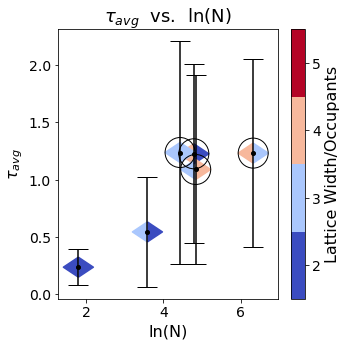

In [36]:
def make_avg_plots(data, log=False):
    
    dim,occ = [ds.dim for ds in data],[ds.occ for ds in data]
    N = [math.log(choose(d*d, o))*log + choose(d*d, o)*(not log) for d,o in zip(dim,occ)]
    tau_avg, tau_std = [], []
    for dir_ in data:
        taus = [ds.tau_critical for ds in dir_.mcdb_data]
        tau_avg.append(np.average(taus)), tau_std.append(np.std(taus))
        
    fig = plt.figure(figsize=(5,5))    
    plt.title(r"$\tau_{avg}$"+"  vs.  "+"N"*(not log)+"ln(N)"*log),
    plt.ylabel(r"$\tau_{avg}$"),plt.xlabel("N"*(not log)+"ln(N)"*log)
    plt.errorbar(np.array(N)[::-1],tau_avg[::-1], yerr=tau_std[::-1],capsize=10,fmt='o', color='black')
    plt.scatter(np.array(N)[::-1],tau_avg[::-1], cmap=cmap, c=dim[::-1], marker=8, s=400, norm=matplotlib.colors.BoundaryNorm(np.arange(1.5,6.5,1), cmap.N))
    plt.scatter(np.array(N)[::-1],tau_avg[::-1], cmap=cmap, c=occ[::-1], marker=9, s=400, norm=matplotlib.colors.BoundaryNorm(np.arange(1.5,6.5,1), cmap.N))
    plt.colorbar(label="Lattice Width/Occupants", ticks=np.arange(2,7,1))
    circles_x, circles_y = [],[]
    for x in range(len(N)):
        if(dim[x] == 3 and occ[x] == 3): circles_x.append(N[x]), circles_y.append(tau_avg[x])
        if(dim[x] == 3 and occ[x] == 4): circles_x.append(N[x]), circles_y.append(tau_avg[x])
        if(dim[x] == 4 and occ[x] == 2): circles_x.append(N[x]), circles_y.append(tau_avg[x])
        if(dim[x] == 4 and occ[x] == 3): circles_x.append(N[x]), circles_y.append(tau_avg[x])
    plt.scatter(circles_x,circles_y,facecolors='none', edgecolors='black', s=900)

    plt.tight_layout(pad=1)
    plt.savefig("figures/scaled.pdf")
    
    plt.show()

    
make_avg_plots(data, log=True)

# Getting the baseline correlation output given a M and N jumps

In [11]:
def protocol_correlation_func2(p1, p2):   
    total_overlap, time_previous, p1_on, p2_on = 0,0,1,1
    combined = sorted(p1+p2)
    for time in combined:
        change = time-time_previous
        if(p1_on == p2_on): total_overlap += change
        if time in p1: p1_on = (p1_on + 1) %2
        if time in p2: p2_on = (p2_on + 1) %2
        time_previous = time
    
    return total_overlap
    



from numpy import random
LOOPS = 10000
M, N,max_jumps = 1, 1,5
info = []
for M in range(1,max_jumps+1,1):
    for N in  range(1,max_jumps+1,1):
        sum = 0
        print(M,N)
        for x in range(int(LOOPS/4)):
            t1 = list(random.rand(2*M))
            t2 = list(random.rand(2*N))
            t1.append(1), t2.append(1)
            overlap = protocol_correlation_func2(t1,t2)
            sum += overlap
        for x in range(int(LOOPS/4)):
            t1 = list(random.rand(2*M+1))
            t2 = list(random.rand(2*N+1))
            t1.append(1), t2.append(1)
            overlap = protocol_correlation_func2(t1,t2)
            sum += overlap
        for x in range(int(LOOPS/4)):
            t1 = list(random.rand(2*M))
            t2 = list(random.rand(2*N+1))
            t1.append(1), t2.append(1)
            overlap = protocol_correlation_func2(t1,t2)
            sum += overlap
        for x in range(int(LOOPS/4)):
            t1 = list(random.rand(2*M+1))
            t2 = list(random.rand(2*N))
            t1.append(1), t2.append(1)
            overlap = protocol_correlation_func2(t1,t2)
            sum += overlap
        info.append([M,N,sum/LOOPS])
        
print(info)

1 1
1 2
1 3
1 4
1 5
2 1
2 2
2 3
2 4
2 5
3 1
3 2
3 3
3 4
3 5
4 1
4 2
4 3
4 4
4 5
5 1
5 2
5 3
5 4
5 5
[[1, 1, 0.5387556677972538], [1, 2, 0.5323450694644379], [1, 3, 0.52386011264428], [1, 4, 0.5217008778152737], [1, 5, 0.5147194943435496], [2, 1, 0.5309481668099962], [2, 2, 0.5243066372542639], [2, 3, 0.52108035146241], [2, 4, 0.5189683139756341], [2, 5, 0.51592193217535], [3, 1, 0.5270097968763682], [3, 2, 0.5196533459650722], [3, 3, 0.5180855350491896], [3, 4, 0.5157616930313778], [3, 5, 0.5141548790705144], [4, 1, 0.5208964051630999], [4, 2, 0.5174049791784847], [4, 3, 0.516589279089822], [4, 4, 0.5143072755936978], [4, 5, 0.5129547336472938], [5, 1, 0.5172690420472408], [5, 2, 0.5159372205118089], [5, 3, 0.5136185531994105], [5, 4, 0.5113594201523222], [5, 5, 0.5127158514558877]]


In [21]:
sum = 0
for x in range(LOOPS):
    t1 = list(random.rand(2))
    t2 = list(random.rand(2))
    t1.append(1), t2.append(1)
    overlap = protocol_correlation_func2(t1,t2)
    sum += overlap
print(sum/LOOPS)

0.5996372837334853


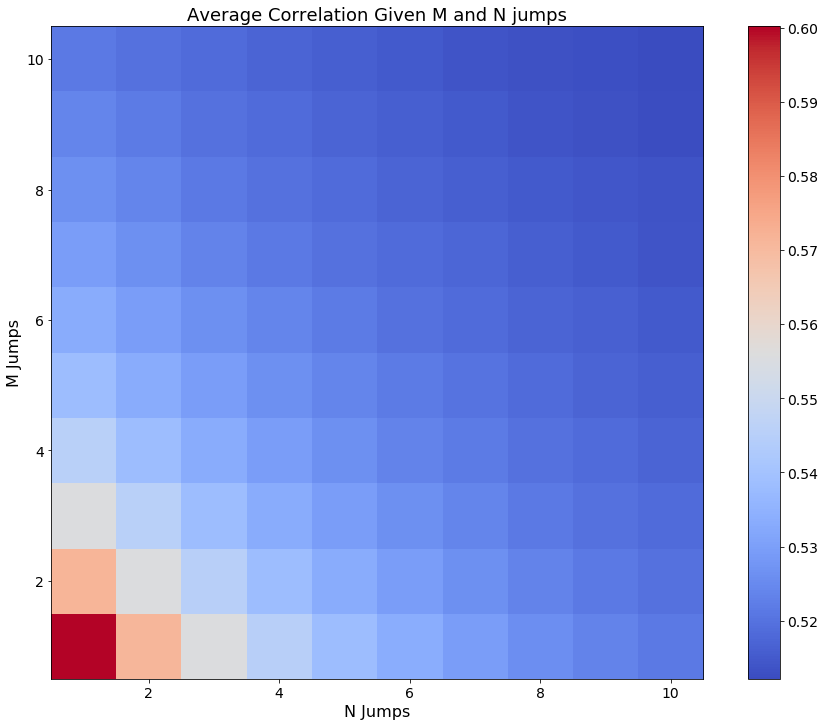

In [271]:
expected_correlations = [[0.600147699776004, 0.5712338748765787, 0.5555706967606777, 0.545351209247155, 0.5385122185142767, 0.5335012020313474, 0.5293666881686706, 0.5259367785861887, 0.5238379223172802, 0.5216693681525312], [0.5712929959015195, 0.5555713057017088, 0.5453883225405965, 0.5385595284656947, 0.5332274057739077, 0.5294230035598351, 0.5263729469380182, 0.5237016184402828, 0.5216695264578064, 0.5199314875204598], [0.5556319572257781, 0.5456761455174851, 0.5384495817319188, 0.5331442968545845, 0.5294449798813218, 0.5265139448953233, 0.5239297876122827, 0.5216165044533978, 0.5199609420884219, 0.5185286101250256], [0.5455508272871546, 0.5383901612266245, 0.5332787307409023, 0.5294839522564326, 0.5263652388409229, 0.5238420190190826, 0.5218591701565214, 0.5200402837103295, 0.5186079110502778, 0.5171385712163025], [0.5384483814457044, 0.533418958468794, 0.5294713196588129, 0.5264563917918658, 0.5238889397143583, 0.5218897823623183, 0.5201441959910578, 0.5185074994355018, 0.5172205738897399, 0.5162763929423091], [0.5333681889795245, 0.5294580039600845, 0.5264955121633532, 0.5238787681787044, 0.5217922557062405, 0.5198880075237334, 0.5184343127966805, 0.5172295750325734, 0.5162921032332515, 0.5151550668422256], [0.5295057310160771, 0.526327509178634, 0.5236768475898073, 0.521693164949027, 0.5199382197671717, 0.5185104651267554, 0.5173439007974567, 0.5159828733240488, 0.5152130447646509, 0.514171569975028], [0.5263374296354152, 0.5239081033380923, 0.521738951031868, 0.5199491475361656, 0.5185300834998675, 0.5172774565162734, 0.5161220947223192, 0.5152386380120277, 0.5142645985315033, 0.5135437387051474], [0.523995327410501, 0.521836177931003, 0.5199402753868384, 0.5186277629012794, 0.5170762214438477, 0.516129752394632, 0.5152403325768585, 0.5141881920747723, 0.5134750261942919, 0.5128472724710921], [0.5216974886704653, 0.5200640505739937, 0.5184879226904646, 0.517226650454048, 0.5162065085226006, 0.5150594402109683, 0.5142204109955493, 0.5134182267436602, 0.5128908595219885, 0.5121670079612185]]

fig = plt.figure(figsize=(16, 12))
plt.title("Average Correlation Given M and N jumps")
plt.ylabel("M Jumps")
plt.xlabel("N Jumps")

plt.imshow(np.array(expected_correlations), extent=[0.5,10.5,0.5,10.5], origin='lower', cmap=cmap)
plt.colorbar()
plt.savefig("Figures/corr_vs_jumps_plot.pdf")

# Checking the cost and distance function vs the ratio of j and k for random states

In [101]:
import pandas as pd
f = open("../data/test_cost.txt", "rt")
ji, ki,ratios, jt, kt, cost, dist, states = [],[],[],[],[],[],[],[]


for line in f:
    if "#" in line: continue
    ogline = (line.rstrip())
    line = ogline.split(" ")
    ji.append(float(line[0]))
    ki.append(float(line[1]))
    ratios.append(float(line[2])/float(line[3]))
    jt.append(float(line[2]))
    kt.append(float(line[3]))
    cost.append(float(line[4]))
    dist.append(float(line[5]))
    start = ogline.index("[")
    states.append(literal_eval(ogline[start:]))
    
data = [ji, ki,ratios, jt, kt, cost, dist, states]

In [102]:
for x in range(len(dist)):
    if(abs(jt[x]/kt[x] - ji[x]/ki[x]) == 0): dist[x] = 0
for x in range(len(dist)):
    if dist[x] < 0: print(dist[x], ji[x], ki[x], jt[x], kt[x])

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


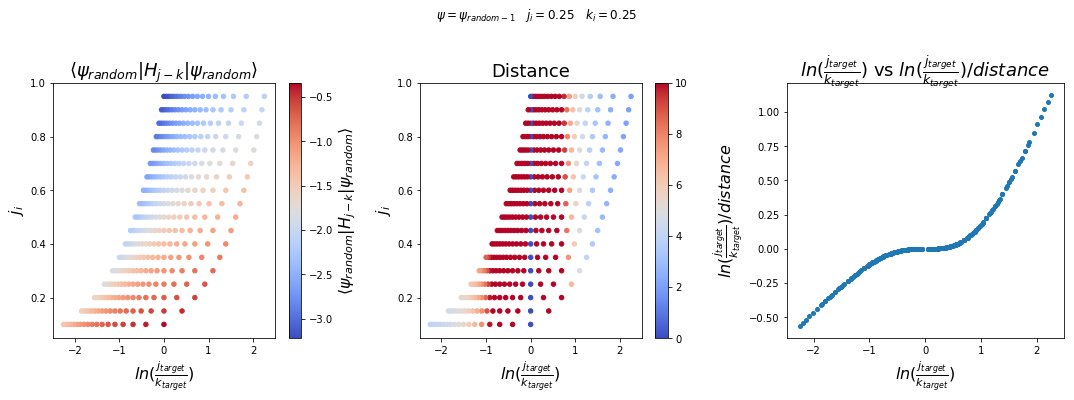

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


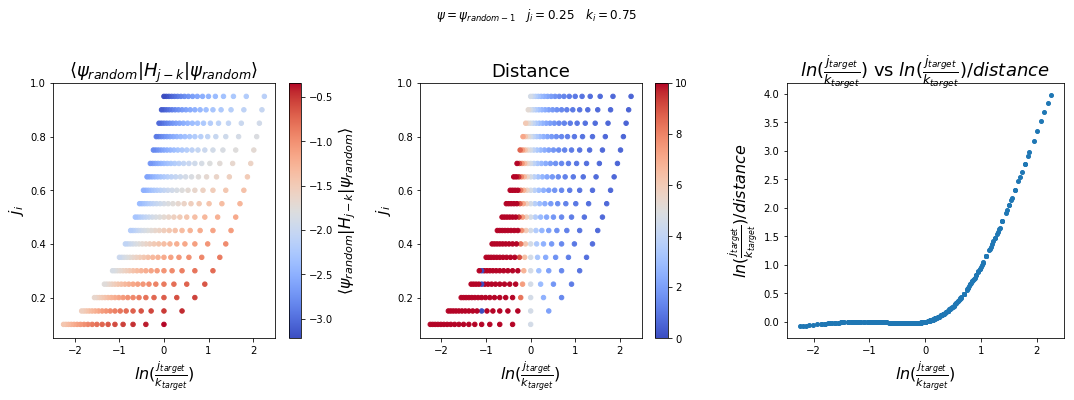

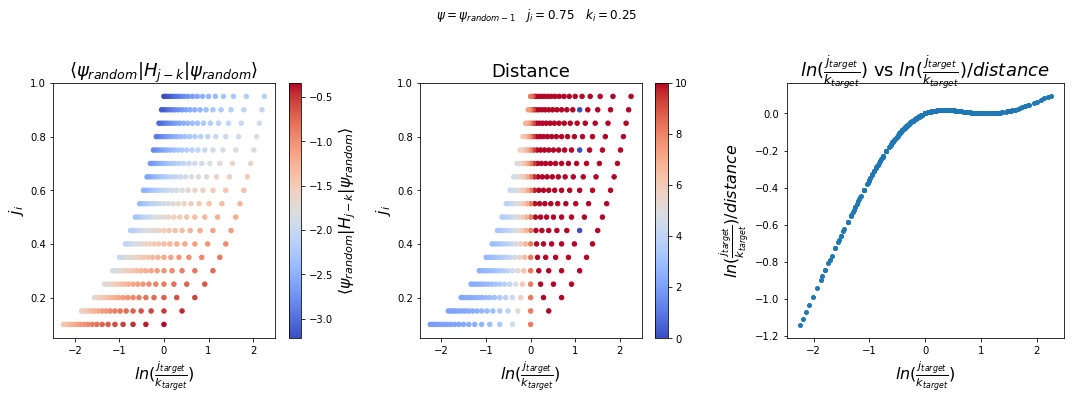

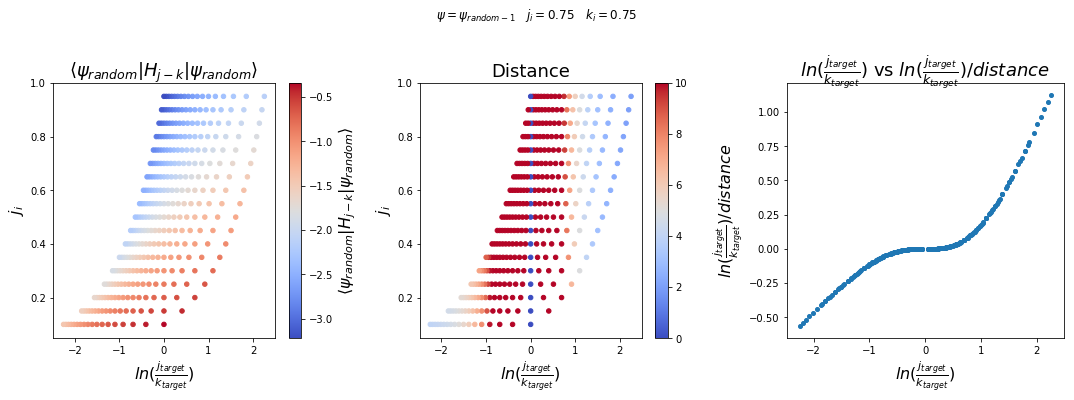

In [123]:
for x in range(2*2):
    data_for_init = []
    for item in data: data_for_init.append(item[x*324:(x+1)*324])
    ji, ki,ratios,jt,kt,cost,dist,states= data_for_init[0],data_for_init[1],data_for_init[2],data_for_init[3],data_for_init[4],data_for_init[5],data_for_init[6],data_for_init[7]
    if(ji[0] != ji[-1] or ki[0] != ki[-1] or states[0] != states[-1] or ratios[0] != ratios[-1]): print("ji ERROR")
    
    fig = plt.figure(figsize=(15,5))
    fig.suptitle(r"$\psi = \psi_{random-1}$"+"   "+r"$j_i = $" +str(ji[0])+ "   "+r"$  k_i = $" + str(ki[0]),y=1.1)
    
    fig.add_subplot(1, 3, 1)
    plt.title(r"$\langle\psi_{random}|H_{j-k}|\psi_{random}\rangle$"),plt.ylabel(r"$j_i$"),plt.xlabel(r"$ln(\frac{j_{target}}{k_{target}})$")
    plt.scatter(np.log(ratios), jt, s=20, c = cost, cmap=cmap)
    plt.colorbar(label = r"$\langle\psi_{random}|H_{j-k}|\psi_{random}\rangle$")
    
    fig.add_subplot(1, 3, 2)
    plt.title("Distance"),plt.ylabel(r"$j_i$"),plt.xlabel(r"$ln(\frac{j_{target}}{k_{target}})$")
    plt.scatter(np.log(ratios), jt, s=20, c = dist, cmap=cmap, vmin=0, vmax = 10)
    plt.colorbar()#label = r"$\langle\psi_{random}|H_{j-k}|\psi_{random}\rangle$")
    
    fig.add_subplot(1, 3, 3)
    plt.title(r"$ln(\frac{j_{target}}{k_{target}})$"+" vs "+r"$ln(\frac{j_{target}}{k_{target}})/distance$")
    plt.ylabel(r"$ln(\frac{j_{target}}{k_{target}})/distance$"), plt.xlabel(r"$ln(\frac{j_{target}}{k_{target}})$")
    plt.scatter(np.log(ratios), np.log(ratios)/np.array(dist))
    plt.tight_layout(pad=1)
    plt.show()

# Plotting dimension over system size and occupancy

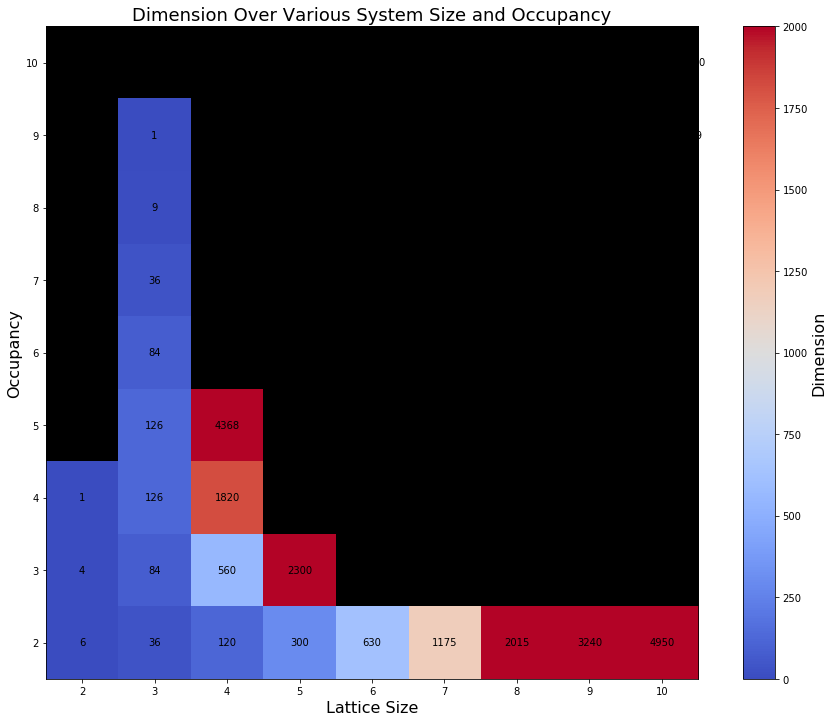

In [237]:
nx_list = [2,3,4,5,6,7,8,9,10]
data = []
for nx in nx_list:
    occ=2
    dimension = 0
    while(occ <= 10):
        dimension = int(choose(nx*nx, occ))
        data.append([nx, occ, dimension])
        occ += 1
nx,occ,N = np.array(data).T[0],np.array(data).T[1],np.array(data).T[2]

x_start = 1.5
x_end = 10.5
y_start = 1.5
y_end = 10.5
size = 9
extent = [x_start, x_end, y_start, y_end]
data = np.reshape(N, (size,size)).T[::-1]
# The normal figure
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
plt.title("Dimension Over Various System Size and Occupancy")
plt.ylabel("Occupancy"), plt.xlabel("Lattice Size")
plt.yticks([2, 3, 4, 5, 6, 7, 8, 9, 10]),plt.xticks([2, 3, 4, 5, 6, 7, 8, 9, 10])


masked_data = np.ma.masked_where(data >5000, data)
masked_data = np.ma.masked_where(data == -1, masked_data)
cmap.set_bad(color='black')
im = ax.imshow(masked_data,extent=extent,cmap=cmap, vmin=0, vmax = 2000)



jump_x = (x_end - x_start) / (2.0 * size)
jump_y = (y_end - y_start) / (2.0 * size)
x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        label = data[8-y_index,x_index]
        text_x = x + jump_x
        text_y = y + jump_y
        ax.text(text_x, text_y, round(label, 4), color='black', ha='center', va='center')

fig.colorbar(im, label="Dimension")
plt.savefig("figures/dimension_vs_system.pdf")
plt.show()

# Interpolation

In [54]:
#for the interpolation, we want:
#tau, the time of the nearest neighbor jumps, the best energy
#a nice way to save the old data and add on the new jumps
# input the jumps of two neighbors in either direction

def get_data_set(data_mcbb_whole, dir_, ji, ki, jt, kt):
    index = []
    for x in range(len(data_mcbb_whole[0])):
        conditions = ["ji="+str(ji) in data_mcbb_whole[0][x], 
                      "ki="+str(ki) in data_mcbb_whole[0][x],
                      "jt="+str(jt) in data_mcbb_whole[0][x],
                      "kt="+str(kt) in data_mcbb_whole[0][x],
                      dir_ in data_mcbb_whole[0][x]]
        if(all(conditions)): index.append(x)
    if(len(index) != 1):print("\n\nERROR\n\n")
    else: return data_mcbb_whole[1][index[0]]
    
my_dirs = ['../data/3x3/3_occupants']  
interpolation_info = [[0.05, 0.05, [[0.35,0.95], [0.65, 0.95]], "j"],
                     ]
for interp_set in interpolation_info:
    ji = interp_set[0]
    ki = interp_set[1]
    target1 = interp_set[2][0]
    target2 = interp_set[2][1]
    j_or_k = interp_set[3]
    jt1, kt1 = target1[0], target1[1]
    jt2, kt2 = target2[0], target2[1]
    data1 = get_data_set(data_mcbb_whole, my_dirs[0], ji, ki, jt1, kt1)
    data2 = get_data_set(data_mcbb_whole, my_dirs[0], ji, ki, jt2, kt2)
    data_to_change = get_data_set(data_mcbb_whole, my_dirs[0], ji, ki, (jt1+jt2)/2, (kt1+kt2)/2)

    p1 = get_values(data1, "j_protocols_reduced")[-1]
    p2 = get_values(data2, "j_protocols_reduced")[-1]

    if(len(p1) != len(p2)): print("ERROR, Protocols don't have the same number of jumps")
    new_j_jumps = []
    for t1, t2 in zip(p1, p2):
        new_j_jumps.append((t1+t2)/2)
        
    p1 = get_values(data1, "k_protocols_reduced")[-1]
    p2 = get_values(data2, "k_protocols_reduced")[-1]

    if(len(p1) != len(p2)): print("ERROR, Protocols don't have the same number of jumps")
    new_k_jumps = []
    for t1, t2 in zip(p1, p2):
        new_k_jumps.append((t1+t2)/2)
        
    print("\nji="+str(ji)+" ki="+str(ki)+" jt="+str((jt1+jt2)/2)+" kt="+str((kt1+kt2)/2))
    print("tau="+str(get_values(data_to_change, "tau_array")[-1])+"  best_E="+str(get_values(data_to_change, "best_E_array")[-1]))
#     print("Old j=")
#     print(get_values(data_to_change, "j_protocols_reduced")[-1])
#     print("Old k=")
#     print(get_values(data_to_change, "k_protocols_reduced")[-1])
    print("new Tau = " + str((get_values(data1, "tau_array")[-1]+get_values(data2, "tau_array")[-1])/2))
    print("New j=")
    print(new_j_jumps)
    print("New k=")
    print(new_k_jumps)


ji=0.05 ki=0.05 jt=0.5 kt=0.95
tau=0.532091  best_E=-7.46092
new Tau = 0.5059985
New j=
[0.053341200000000005, 0.207361, 0.2827445, 0.42718500000000004]
New k=
[0.00540225, 0.437875]


#  Gap Plot

In [ ]:
def plot_gap():
    filepath = '../data/gap.txt'
    j, k, gap = [],[],[]
    
    for line in open(filepath, "rt"):     
        line = line.rstrip("\n")
        if line.startswith('gap'): gap.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('j'):   j.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('k'):   k.append(literal_eval((line.split('=')[-1]).replace(" ", "")))

    plt.figure()
    plt.ylabel("k")
    plt.xlabel("j")
    plt.ylim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    plt.scatter(j, k, c=gap, cmap = cmap, s = 10, alpha=0.7)
    cbar = plt.colorbar(label = 'gap')
    #plt.scatter(0.1, 0.1, s = 100, c = 'pink', label = 'initial')
    #plt.scatter(1, 1, s = 100, c = 'black', label = 'target')
    #plt.legend()
    plt.savefig("../data/gap_plot_3x3_4_occ.pdf")
    plt.show()

plot_gap()

# Creating the Directory Structure

In [3]:
max_lattice_size = 6
'''Rectangular Lattice
for n in range(2,max_lattice_size+1):
    for m in range(2,max_lattice_size+1):
        for x in  range(2, m*n-1):
            if(m>=n): #preventing creation of both mxn and nxm
                dir = '../data/'+str(n)+'x'+str(m)+'/'+str(x)+'_occupants'
                if not os.path.exists(dir):
                    os.makedirs(dir)
'''
#Square Lattice
for n in range(2,max_lattice_size+1):
    for x in  range(2, n*n-1):
        dir = '../data/'+str(n)+'x'+str(n)+'/'+str(x)+'_occupants'
        if not os.path.exists(dir):
            os.makedirs(dir)            

In [11]:
for my_dir in my_dirs:
    for filepath in glob.iglob(my_dir + '*.txt'):
        reading_file = open(filepath, "r")

        new_file_content = ""

        for line in reading_file:     
            stripped_line = line.strip()
            if "best_E" in line: new_line = stripped_line.replace("best_E", "best_mc_result")
            else: new_line = stripped_line
            new_file_content += new_line +"\n"
        reading_file.close()

        writing_file = open(filepath, "w")
        writing_file.write(new_file_content)
        writing_file.close()

# Old Plotting Functions

In [14]:
def make_plots(data, group_plot_params, target_comparison_sets,ji_list = [0.05,0.95], ki_list = [0.05,0.95],dim = 0, occ = 0, save=False, log=True, cp=False, rp=False, gp=False, tau_extrapolated = False):
    
    M,N = 12, 2 

    titles = [r'$\tau_c$ MCDB', r'$|\langle\psi_{evolved}|\psi_{target}\rangle|^2$',r'$\tau_c$ Adiabatic',r'$|\langle\psi_{evolved}|\psi_{target}\rangle|^2$'
              ,r'$|\langle\psi_{initial}|\psi_{target}\rangle|^2$',r'$E_{initial}-E_{ground}$',r'$N_{j-jumps}$',r'$N_{k-jumps}$',
              r"$C(\{j_i\})_{modified}$",r"$C(\{k_i\})_{modified}$", r"$C(\{j_i\})_{modified}$",r"$C(\{k_i\})_{modified}$",
              r"$C(\{j_i\})_{modified}$",r"$C(\{k_i\})_{modified}$", r"$C(\{j_i\})_{modified}$",r"$C(\{k_i\})_{modified}$",
              r"$j_{on}/(\tau_c * N_{j-jumps})$",r"$k_{on}/(\tau_c * N_{k-jumps})$",r"$j_{off}/(\tau_c * N_{j-jumps})$",r"$k_{off}/(\tau_c * N_{k-jumps})$",
              r"$j_{on}/\tau_c$",r"$k_{on}/\tau_c$",r"$j_{off}/\tau_c$",r"$k_{off}/\tau_c$",]
    v_range = [[None, None],[0.5, 1],[None, None],[0.5, 1],[None, None],[None, None],[0, 7],[0, 7],
               [-0.55, .65],[-0.55, .65],[-0.55, .65],[-0.55,.65],[-0.55, .65],[-0.55, .65],[-0.55, .65],[-0.55, .65],
               [0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],]
    norm = [None, None, None, None, None,None, matplotlib.colors.BoundaryNorm(np.arange(-0.5,5.5,1), cmap.N), matplotlib.colors.BoundaryNorm(np.arange(-0.5,5.5,1), cmap.N), 
            None, None,None, None, None, None, None, None, None, None, None, None, None, None, None, None]
    ticks = [None, None, None, None, None,None, np.linspace(0,5,6), np.linspace(0,5,6), 
             np.arange(-0.45,0.66,0.2), np.arange(-0.45,0.66,0.2), np.arange(-0.45,0.66,0.2), np.arange(-0.45,0.66,0.2), 
             np.arange(-0.45,0.66,0.2), np.arange(-0.45,0.66,0.2), np.arange(-0.45,0.66,0.2), np.arange(-0.45,0.66,0.2), 
             np.arange(-0,1.01,0.2),np.arange(-0,1.01,0.2), np.arange(-0,1.01,0.2), np.arange(-0,1.01,0.2),
             np.arange(-0,1.01,0.2),np.arange(-0,1.01,0.2), np.arange(-0,1.01,0.2), np.arange(-0,1.01,0.2),]
    
    for dir_ in data:
        if(dim and not(dir_.dim == dim)): continue
        if(occ and not(dir_.occ == occ)): continue
        for ji in ji_list:
            for ki in ki_list:
                
                mcdb_init,adia_init = get_data_sets(dir_.mcdb_data, ji, ki), get_data_sets(dir_.adia_data, ji, ki)
                
                if(cp and len(mcdb_init) == 169 and len(adia_init) == 169): color_plot_2d(mcdb_init, adia_init,titles, ticks, v_range, norm,M,N,target_comparison_sets, save,tau_extrapolated)
                if(rp): ratio_plot_2d(mcdb_init, adia_init,titles, ticks, v_range, norm,M,N,target_comparison_sets, log,save,tau_extrapolated)
        if(gp and len(dir_.mcdb_data)==169*4):
            for x in range(len(group_plot_params)):
                protocol_group_plot(dir_,group_plot_params[x][0],group_plot_params[x][1],group_plot_params[x][2],group_plot_params[x][3],save)

            
def save_plot(dir_, title):
    if not os.path.exists("figures/" + dir_): os.makedirs("figures/" + dir_)
    plt.savefig("figures/" + dir_ + title + ".pdf")
    

def step_plot(x, y, title, x_label,color, y_label, x_upper, x_lower, y_upper, y_lower):
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.xlim(x_lower, x_upper)
    plt.ylim(y_lower, y_upper)
    if(x[0]!=0): x.insert(0,0), y.insert(0,1)
    plt.step(x,y, c=color)

     

def color_plot_2d(mcdb_data, adia_data,titles, ticks, v_range, norm,M,N,target_comparison_sets,data_save,t): 
    data = [[ds.tau_critical*(not t) + ds.tau_extrapolated*t for ds in mcdb_data],[ds.overlap_array[-1] for ds in mcdb_data],
            [ds.tau_critical*(not t) + ds.tau_extrapolated*t for ds in adia_data], [ds.overlap_array[-1] for ds in adia_data], 
            [ds.init_target_dot_squared for ds in mcdb_data], [ds.ground_e-ds.initial_e for ds in mcdb_data], 
            [ds.j_jumps[-1] for ds in mcdb_data], [ds.k_jumps[-1]  for ds in mcdb_data], 
            [ds.comparisons[0][0] for ds in mcdb_data], [ds.comparisons[0][1] for ds in mcdb_data], 
            [ds.comparisons[1][0] for ds in mcdb_data], [ds.comparisons[1][1] for ds in mcdb_data], 
            [ds.comparisons[2][0] for ds in mcdb_data], [ds.comparisons[2][1] for ds in mcdb_data],                     
            [ds.comparisons[3][0] for ds in mcdb_data], [ds.comparisons[3][1] for ds in mcdb_data],  
            [ds.j_char_and_total_time_over_tau[-1][0] for ds in mcdb_data], [ds.k_char_and_total_time_over_tau[-1][0] for ds in mcdb_data], 
            [ds.j_char_and_total_time_over_tau[-1][1] for ds in mcdb_data], [ds.k_char_and_total_time_over_tau[-1][1] for ds in mcdb_data],
            [ds.j_char_and_total_time_over_tau[-1][2] for ds in mcdb_data], [ds.k_char_and_total_time_over_tau[-1][2] for ds in mcdb_data], 
            [ds.j_char_and_total_time_over_tau[-1][3] for ds in mcdb_data], [ds.k_char_and_total_time_over_tau[-1][3] for ds in mcdb_data],]

    skip_list = (np.reshape([ds.skip for ds in mcdb_data], (13, 13)).T)[::-1]
    v_range[1][0], v_range[3][0] = min(data[4]), min(data[4])

    fig = plt.figure(figsize=(N*8,M*8))
    fig.suptitle(r"$N_{grid}$ = "+str(mcdb_data[0].dim)+"    Occupants = "+str(mcdb_data[0].occ)+r"    $j_{initial}$ = "+str(mcdb_data[0].ji)+ r"    $k_{initial}$ = "+str(mcdb_data[0].ki), y=1.01)
    
    index = 0

    for x in range(M*N):
        
        fig.add_subplot(M, N, x+1)
        plt.title(titles[x]), plt.ylabel(r'$k_{target}$'),plt.xlabel(r'$j_{target}$'), plt.yticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]), plt.xticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95])
        plotting_data = (np.reshape(data[x], (13, 13)).T)[::-1]
        plotting_data = np.ma.masked_where(skip_list == True, plotting_data)
        cmap.set_bad(color='white')
        offset=0.01
        extent = [offset,1-offset,offset,1.0-offset]
        plt.imshow(plotting_data, extent=extent, cmap=cmap, vmin = v_range[x][0], vmax =  v_range[x][1], norm=norm[x])
        cbar = plt.colorbar(ticks=ticks[x])
        if(8<=x<16):
            
            plt.scatter(target_comparison_sets[int(floor(index))][0], target_comparison_sets[int(floor(index))][1], s=1000, marker="s",facecolors='none', edgecolors='black',linewidths=4)
            index+=0.5

    fig.tight_layout()   
    if(data_save): save_plot(str(mcdb_data[0].dim)+"x"+str(mcdb_data[0].dim)+"/"+str(mcdb_data[0].occ)+"_occupants/", "cp_ji_" + str(mcdb_data[0].ji) + "_ki_" +str(mcdb_data[0].ki))
    plt.show()

#     index = 0
#     for x in range(M*N):
#         plt.figure()
#         plt.title(titles[x]), plt.ylabel(r'$k_{target}$'),plt.xlabel(r'$j_{target}$'), plt.yticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]), plt.xticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95])
#         plotting_data = (np.reshape(data[x], (13, 13)).T)[::-1]
#         plotting_data = np.ma.masked_where(skip_list == True, plotting_data)
#         cmap.set_bad(color='white')
#         offset=0.01
#         extent = [offset,1-offset,offset,1.0-offset]
#         plt.imshow(plotting_data, extent=extent, cmap=cmap, vmin = v_range[x][0], vmax =  v_range[x][1], norm=norm[x])
#         cbar = plt.colorbar(ticks=ticks[x])
#         if(8<=x<16):
#             plt.scatter(target_comparison_sets[int(floor(index))][0], target_comparison_sets[int(floor(index))][1], s=1000, marker="s",facecolors='none', edgecolors='black',linewidths=4)
#             index+=0.5
#         save_title = ("cp"+str(x)+"_"+str(mcdb_data[0].dim)+"x"+str(mcdb_data[0].dim)+"_"+str(mcdb_data[0].occ)+"_occupants_ji_" + str(mcdb_data[0].ji) + "_ki_" +str(mcdb_data[0].ki)).replace(".","")
#         if(data_save): save_plot(str(mcdb_data[0].dim)+"x"+str(mcdb_data[0].dim)+"/"+str(mcdb_data[0].occ)+"_occupants/", save_title)
#         plt.close()  

    
def ratio_plot_2d(mcdb_data, adia_data,titles, ticks, v_range, norm,M,N,target_comparison_sets, log,data_save,t): 
    M=M+1
    if(log): x_data = [math.log(ds.jt/ds.kt) for ds in mcdb_data]
    else: x_data = [ds.jt/ds.kt for ds in mcdb_data]  
        
    x_data_adia = [math.log(ds.jt/ds.kt) for ds in adia_data]

    y_data = [[ds.tau_critical*(not t) + ds.tau_extrapolated*t for ds in mcdb_data],[ds.overlap_array[-1] for ds in mcdb_data],
            [ds.tau_critical*(not t) + ds.tau_extrapolated*t for ds in adia_data], [ds.overlap_array[-1] for ds in adia_data], 
            [ds.init_target_dot_squared for ds in mcdb_data], [ds.ground_e-ds.initial_e for ds in mcdb_data], 
            [ds.j_jumps[-1] for ds in mcdb_data], [ds.k_jumps[-1]  for ds in mcdb_data], 
            [ds.comparisons[0][0] for ds in mcdb_data], [ds.comparisons[0][1] for ds in mcdb_data], 
            [ds.comparisons[1][0] for ds in mcdb_data], [ds.comparisons[1][1] for ds in mcdb_data], 
            [ds.comparisons[2][0] for ds in mcdb_data], [ds.comparisons[2][1] for ds in mcdb_data],                     
            [ds.comparisons[3][0] for ds in mcdb_data], [ds.comparisons[3][1] for ds in mcdb_data],           
            [ds.j_char_and_total_time_over_tau[-1][0] for ds in mcdb_data], [ds.k_char_and_total_time_over_tau[-1][0] for ds in mcdb_data], 
            [ds.j_char_and_total_time_over_tau[-1][1] for ds in mcdb_data], [ds.k_char_and_total_time_over_tau[-1][1] for ds in mcdb_data],
            [ds.j_char_and_total_time_over_tau[-1][2] for ds in mcdb_data], [ds.k_char_and_total_time_over_tau[-1][2] for ds in mcdb_data], 
            [ds.j_char_and_total_time_over_tau[-1][3] for ds in mcdb_data], [ds.k_char_and_total_time_over_tau[-1][3] for ds in mcdb_data],]

    v_range[1][0], v_range[3][0] = min(y_data[4]), min(y_data[4])

    fig = plt.figure(figsize=(N*8,M*8))
    fig.suptitle(r"$N_{grid}$ = "+str(mcdb_data[0].dim)+"    Occupants = "+str(mcdb_data[0].occ)+r"    $j_{initial}$ = "+str(mcdb_data[0].ji)+ r"    $k_{initial}$ = "+str(mcdb_data[0].ki), y=1.01)
    index = 0

    for x in range((M-1)*N):
        fig.add_subplot(M, N, x+1)
        plt.xlabel(r"$ln(\frac{j_{target}}{k_{target}})$"),plt.ylabel(titles[x])
        if(v_range[x][0] != None): plt.ylim(v_range[x][0], v_range[x][1])
        plt.title(titles[x]) 
        if(x == 2 or x ==3): plt.scatter(x_data_adia, y_data[x], c="black", s=20)
        else: plt.scatter(x_data, y_data[x], c="black", s=20)
                       
        if(8<=x<16 and len(mcdb_data)==169):
            jt_comp, kt_comp = target_comparison_sets[int(floor(index))][0], target_comparison_sets[int(floor(index))][1]
            ds_comp_val = get_data_sets(mcdb_data, mcdb_data[0].ji, mcdb_data[0].ki,jt_comp, kt_comp)[0].comparisons[int(floor(index))][int(x%2)]
            target_ratio = math.log(jt_comp/kt_comp)
            plt.scatter(target_ratio, ds_comp_val, lw=3, color="r", marker="+", s=300)

            index+=0.5
  
    
    colors = ["b","g","r","c","b","g","r","c","b","g","r","c","b","g","r","c","b","g","r","c","b","g","r","c",]
    fig.add_subplot(M, N, M*N-1)
    plt.xlabel(r"$ln(\frac{j_{target}}{k_{target}})$"),plt.ylabel(r"$t_{j-jumps}$"),plt.ylim(-0.01,1.01)
    plt.title(r"$t_{j-jumps}$")
    js,ks, x_vals= [np.array(ds.j_protocols_reduced[-1])/ds.tau_critical for ds in mcdb_data], [np.array(ds.k_protocols_reduced[-1])/ds.tau_critical for ds in mcdb_data], []         
    for x in range(len(js)): 
        x_vals.append(np.linspace(x_data[x],x_data[x], len(js[x])))

    for x in range(len(js)):
        for y in range(len(js[x])):
            plt.scatter(x_vals[x][y],js[x][y],c=colors[y], s=40, alpha = 0.5)
    fig.add_subplot(M, N, M*N)
    plt.xlabel(r"$ln(\frac{j_{target}}{k_{target}})$"),plt.ylabel(r"$t_{k-jumps}$"),plt.ylim(-0.01,1.01)
    plt.title(r"$t_{k-jumps}$")
    x_vals = []
    for x in range(len(ks)): 
        x_vals.append(np.linspace(x_data[x],x_data[x], len(ks[x])))
    for x in range(len(ks)): 
        for y in range(len(ks[x])):
            plt.scatter(x_vals[x][y],ks[x][y],c=colors[y], s=40, alpha = 0.5)
            
    fig.tight_layout(pad=1.0)   
    if(data_save): save_plot(str(mcdb_data[0].dim)+"x"+str(mcdb_data[0].dim)+"/"+str(mcdb_data[0].occ)+"_occupants/", "rp_ji_" + str(mcdb_data[0].ji) + "_ki_" +str(mcdb_data[0].ki))
    plt.show() 
    
#     index = 0
#     for x in range((M-1)*N):
#         plt.figure()
#         plt.xlabel(r"$ln(\frac{j_{target}}{k_{target}})$"),plt.ylabel(titles[x])
#         if(v_range[x][0] != None): plt.ylim(v_range[x][0], v_range[x][1])
#         plt.title(titles[x])
#         plt.scatter(x_data, y_data[x], c="black", s=20)
#         if(8<=x<16):
#             jt_comp, kt_comp = target_comparison_sets[int(floor(index))][0], target_comparison_sets[int(floor(index))][1]
#             ds_comp_val = get_data_sets(mcdb_data, mcdb_data[0].ji, mcdb_data[0].ki,jt_comp, kt_comp)[0].comparisons[int(floor(index))][int(x%2)]
#             target_ratio = math.log(jt_comp/kt_comp)
#             plt.scatter(target_ratio, ds_comp_val, lw=3, color="r", marker="+", s=300)
            
#             index+=0.5
#         save_title = ("rp"+str(x)+"_"+str(mcdb_data[0].dim)+"x"+str(mcdb_data[0].dim)+"_"+str(mcdb_data[0].occ)+"_occupants_ji_" + str(mcdb_data[0].ji) + "_ki_" +str(mcdb_data[0].ki)).replace(".","")
#         if(data_save): save_plot(str(mcdb_data[0].dim)+"x"+str(mcdb_data[0].dim)+"/"+str(mcdb_data[0].occ)+"_occupants/", save_title)
#         plt.close()  

#     colors = ["b","g","r","c","m","b","g","r","c","m",]
#     plt.figure()
#     plt.xlabel(r"$ln(\frac{j_{target}}{k_{target}})$"),plt.ylabel(r"$t_{j-jumps}$"),plt.ylim(-0.01,1.01)
#     plt.title(r"$t_{j-jumps}$")
#     js,ks, x_vals= [np.array(ds.j_protocols_reduced[-1])/ds.tau_critical for ds in mcdb_data], [np.array(ds.k_protocols_reduced[-1])/ds.tau_critical for ds in mcdb_data], []         
#     for x in range(len(js)): 
#         x_vals.append(np.linspace(x_data[x],x_data[x], len(js[x])))

#     for x in range(len(js)):
#         for y in range(len(js[x])):
#             plt.scatter(x_vals[x][y],js[x][y],c=colors[y], s=40, alpha = 0.5)
#     save_title = ("rp"+str(M*N-2)+"_"+str(mcdb_data[0].dim)+"x"+str(mcdb_data[0].dim)+"_"+str(mcdb_data[0].occ)+"_occupants_ji_" + str(mcdb_data[0].ji) + "_ki_" +str(mcdb_data[0].ki)).replace(".","")
#     if(data_save): save_plot(str(mcdb_data[0].dim)+"x"+str(mcdb_data[0].dim)+"/"+str(mcdb_data[0].occ)+"_occupants/", save_title)
#     plt.close()  
  
#     plt.figure()
#     plt.xlabel(r"$ln(\frac{j_{target}}{k_{target}})$"),plt.ylabel(r"$t_{k-jumps}$"),plt.ylim(-0.01,1.01)
#     plt.title(r"$t_{k-jumps}$")
#     x_vals = []
#     for x in range(len(ks)): 
#         x_vals.append(np.linspace(x_data[x],x_data[x], len(ks[x])))
#     for x in range(len(ks)): 
#         for y in range(len(ks[x])):
#             plt.scatter(x_vals[x][y],ks[x][y],c=colors[y], s=40, alpha = 0.5)
            
#     save_title = ("rp"+str(M*N-1)+"_"+str(mcdb_data[0].dim)+"x"+str(mcdb_data[0].dim)+"_"+str(mcdb_data[0].occ)+"_occupants_ji_" + str(mcdb_data[0].ji) + "_ki_" +str(mcdb_data[0].ki)).replace(".","")
#     if(data_save): save_plot(str(mcdb_data[0].dim)+"x"+str(mcdb_data[0].dim)+"/"+str(mcdb_data[0].occ)+"_occupants/", save_title)
#     plt.close()  

      
def protocol_group_plot(dir_,ji,ki,jt,kt,save):

    data_set = get_data_sets(dir_.mcdb_data, ji=ji, ki=ki, jt=jt, kt=kt)[0]

    if(data_set.skip):
        print("No data for group plot comparison, going to the next")
        return

    fig = plt.figure(figsize=(15,6))
    fig.suptitle(r"$N_{grid}$ = "+str(dir_.dim)+"    Occupants = "+str(dir_.occ)+r"    $j_{initial}$ = "+str(ji)+ r"    $k_{initial}$ = "+str(ki)+r"    $j_{target}$ = "+str(jt)+ r"    $k_{target}$ = "+str(kt))
    jkb_vals = [0,1,0,1,0,1,0,1,0,1,0,1,0]
    j,k = ((data_set.j_protocols_reduced[-1]).copy()), ((data_set.k_protocols_reduced[-1]).copy())

    fig.add_subplot(1, 2, 1)
    step_plot(j, jkb_vals[:np.size(j)], '', "Time",'blue' ,'j', data_set.tau_critical, 0, 1.05, -.05)
    fig.add_subplot(1, 2, 2)
    step_plot(k, jkb_vals[:np.size(k)], '', "Time",'limegreen' ,'k', data_set.tau_critical, 0, 1.05, -.05)

    if(save): save_plot(str(dir_.dim)+"x"+str(dir_.dim)+"/"+str(dir_.occ)+"_occupants/", "gp_ji=" + str(ji) + "_ki=" +str(ki)+"jt=" + str(jt) + "_kt=" +str(kt)) 
    plt.show()